<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

### KNOWLEDGE GRAPHS


Our goal in this exercise is to BEGIN coming to a common agreement, among this class, as to what terms we will use as we selectively refine our corpus-wide vocabulary. This corpus vocabulary is what would represent the content of each different document for clustering and classification purposes, which will be our next step. This means that we need to make decisions - what is in, what is out.

In [142]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

import nltk
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Activation, Dropout
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

# importing modules
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import save_model
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 
# nltk.download() # for downloading packages

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 



### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br> 
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Drive

In [143]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### NLTK Downloads

In [144]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [145]:
import pkg_resources
pkg_resources.require("gensim<=3.8.3");

In [146]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.6.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [147]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Utility Functions

In [148]:
def clean_doc_KG(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words_KG(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words_KG(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output


In [149]:
def add_ml_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    display(corpus_df)
    data['Descriptor'] = corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, sep = "\t", engine='python', encoding = "ISO-8859-1" )
    add_ml_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()    

def remove_tags(text):    
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

@dataclass
class Document:
    doc_id: str
    text: str

def normalize_document(document: Document) -> Document:
    text = document.text
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)
    
    return Document(document.doc_id, text)

def normalize_documents(documents: List[Document]) -> List[Document]:
    """
    Normalizes text for all given documents.
    Removes punctuation, converts to lower case, removes tags and special characters.
    """
    return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

def tokenize_document(document: Document) -> TokenizedDocument:
    tokens = nltk.word_tokenize(document.text)
    return TokenizedDocument(document.doc_id, tokens)

def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
    return [tokenize_document(x) for x in documents]

def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    lemmatizer = WordNetLemmatizer()
    for document in documents:
        output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))
        
    return result

def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    stemmer = PorterStemmer()
    for document in documents:
        output_tokens = [stemmer.stem(w) for w in document.tokens]
        result.append(TokenizedDocument(document.doc_id, output_tokens))

    return result

def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
    result = []
    
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    for document in documents:
        filtered_tokens = [w for w in document.tokens if not w in stop_words]
        result.append(TokenizedDocument(document.doc_id, filtered_tokens))
        
    return result
    
def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
    tokens = {y for x in documents for y in x.tokens}
    return sorted(list(tokens))

## Loading the corpus

In [150]:
CORPUS_PATH = 'response_corpus.txt'
corpus_df = get_corpus_df(CORPUS_PATH)

documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

,Doc_ID,DSI_Title,Student Name,Text
0,1,Doc1,Team,Hello! how can i help you ?
1,2,Doc2,Team,"I hope I was able to assist you, Good Bye"
2,3,Doc3,Team,"In statistics, logistic regression, or logit r..."
3,4,Doc4,Team,Logistic regression is used widely in many fie...
4,5,Doc5,Team,Supervised learning is the machine learning ta...
5,6,Doc6,Team,In order to solve a given problem of supervise...
6,7,Doc7,Team,"In statistics, linear regression is an approac..."
7,8,Doc8,Team,"In statistics, logistic regression, or logit r..."
8,9,Doc9,Team,"In mathematical optimization, statistics, deci..."
9,10,Doc10,Team,"In machine learning, the problem of unsupervis..."


1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

## Exploratory Data Analysis

In [151]:
corpus_df.shape

(20, 5)

In [152]:
corpus_df.head().T

Doc_ID,1,10,11,12,13
DSI_Title,Doc1,Doc10,Doc11,Doc12,Doc13
Student Name,Team,Team,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...,Principal component analysis (PCA) is a statis...,Decision tree learning uses a decision tree as...
Descriptor,1,10,11,12,13
Doc_ID,1,10,11,12,13


In [153]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 9
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DSI_Title     20 non-null     object
 1   Student Name  20 non-null     object
 2   Text          20 non-null     object
 3   Descriptor    20 non-null     object
 4   Doc_ID        20 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 960.0+ bytes
None


In [154]:
corpus_df.iloc[0]['Text']

'Hello! how can i help you ?'

In [155]:
!python3 -m spacy download en_core_web_lg

import en_core_web_sm
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 
nlp = spacy.load('en_core_web_lg')

2022-11-12 00:32:47.706056: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 12 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


## spaCy

In [156]:

for i in range(len(corpus_df)):
  displacy.render(nlp(corpus_df.iloc[i]['Text']), style='ent', jupyter=True)

## Standardize Document

1. remove_punctuation(text)
2. lower_case(text)
3. remove_tags(text)
4. remove_special_chars_and_digits(text)
5. return Document(document.doc_id, text)

In [157]:
normalized_documents = normalize_documents(documents)
normalized_documents[0]

Document(doc_id=1, text='hello how can i help you ')

## Tokenized Document

#### NLTK Tokenizer Package

https://www.nltk.org/api/nltk.tokenize.html

Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the words and punctuation in a string:

### Functions for Tokenization Process
1. tokenize_document
2. tokenize_documents

In [158]:
tokenized_documents = tokenize_documents(normalized_documents)
tokenized_documents[0]

TokenizedDocument(doc_id=1, tokens=['hello', 'how', 'can', 'i', 'help', 'you'])

## Qualitative Term Determinations

#### Terms Determined by Document of Interest

<div class="alert alert-block alert-success">
    <b>sklearn.feature_extraction.text.CountVectorizer</b>:<br> 
Convert a collection of text documents to a matrix of token counts.<br>
This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.<br>
If you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.
</div>

In [159]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
text_for_counts = [x.text for x in normalized_documents]
matrix = vectorizer.fit_transform(text_for_counts)
words = vectorizer.get_feature_names()
word_counts = pd.DataFrame(matrix.toarray(), columns=words, index=corpus_df.Doc_ID)

In [160]:
# Collect result into a dataframe
mean_frequencies = pd.DataFrame()
mean_frequencies

""


## TF-IDF Experiment Functions - Text Normalization

In [161]:
def run_tfidf(documents: List[Document],
              clean_func: Callable[[List[Document]], List[TokenizedDocument]],
              experiment_name: str,
              output_tfidf_vectors: bool=False,
              output_vocabulary: bool=True):
    cleaned_documents = clean_func(documents)
    cleaned_document_text = [' '.join(x.tokens) for x in cleaned_documents]
    
    vectorizer = TfidfVectorizer(use_idf=True,
                                 ngram_range=(1, 1),
                                 norm=None)

    transformed_documents = vectorizer.fit_transform(cleaned_document_text)
    transformed_documents_as_array = transformed_documents.toarray()

    output_dir = f'output/{experiment_name}_Results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if output_tfidf_vectors:
        for counter, doc in enumerate(transformed_documents_as_array):
            tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
            one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score'])\
                                        .sort_values(by='score', ascending=False)\
                                        .reset_index(drop=True)

            one_doc_as_df.to_csv(f'{output_dir}/{corpus_df["Submission File Name"][counter]}')
    
    if output_vocabulary:
        with open(f'{output_dir}/vocabulary.txt', 'w') as vocab:
            words = sorted(vectorizer.get_feature_names())
            print('\n'.join(words), file=vocab)

    # Create document-term dataframe
    doc_term_matrix = transformed_documents.todense()
    doc_term_df = pd.DataFrame(doc_term_matrix, 
                               columns=vectorizer.get_feature_names(), 
                               index=corpus_df.Doc_ID)
    
    # Print the top 10 mean TF-IDF values
    top10_tfidf = pd.DataFrame(doc_term_df.mean().sort_values(ascending=False).head(10))
    top10_tfidf.rename(columns={0: 'Mean TF-IDF'}, inplace=True)
    display(top10_tfidf)
    
    # Collect result into a dataframe
    tfidf_results = pd.DataFrame()
 
    plt.hist(doc_term_df.mean(), 100, range=(0, 8))
    
    print(f'Vocabulary size: {doc_term_df.shape[1]}')

## TF-IDF  (Term Frequency-Inverse Document Frequency)

### Experiments, Normalize, Tokenize, Lemmatization and Stop Word Removal

Basline method for cleaning

In [162]:
def clean_baseline_method(documents: List[Document]) -> List[TokenizedDocument]:
    """
    Normalizes text, tokenizes.
    """
    documents = normalize_documents(documents)
    documents = tokenize_documents(documents)
    documents = lemmatize(documents)
    documents = remove_stop_words(documents)
    
    return documents

,Mean TF-IDF
network,7.546756
learning,7.448965
deep,6.628298
regression,6.465543
logistic,5.981013
neural,5.969822
function,4.288943
model,4.286669
layer,4.271570
tree,4.167611


Vocabulary size: 1213


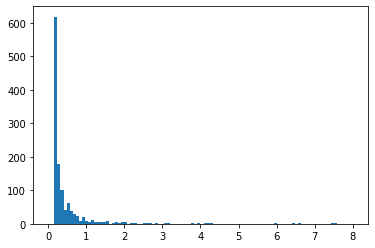

In [163]:
run_tfidf(documents, clean_baseline_method, 'TFIDF_exp')

## Word2Vec

<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

## Utility Functions For Word2Vec Experiments

In [164]:
def get_word2vec_vectors(documents: List[TokenizedDocument], embedding_size: int) -> pd.DataFrame:
    tokens = [x.tokens for x in documents]
    
    word2vec_model = Word2Vec(tokens, size=embedding_size, window=3, min_count=1, workers=12)
    
    vectors = {}
    for i in word2vec_model.wv.vocab:
        temp_vec = word2vec_model.wv[i]
        vectors[i] = temp_vec

    result = pd.DataFrame(vectors).transpose()
    result = result.sort_index()
    return result

def plot_dendrogram(data: pd.DataFrame, experiment_name: str, figsize=(30, 60)):
    plt.figure(figsize=figsize)
    plt.title("Dendrograms")  

    linkage = scipy.cluster.hierarchy.linkage(data, method='ward')
    scipy.cluster.hierarchy.dendrogram(linkage, labels=data.index, leaf_font_size=15, orientation='right')
    #plt.savefig(f'figures/{experiment_name}_dendrogram.png')
    plt.show()
    plt.close()
    
def plot_similarity_matrix(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(ax=ax, data=similarities, xticklabels=data.index, yticklabels=data.index);
    #plt.savefig(f'figures/{experiment_name}_heatmap.png')
    plt.close()
    
def plot_similarity_clustermap(data: pd.DataFrame, experiment_name: str, figsize=(25, 25)):
    similarities = cosine_similarity(data, data)
    cm = sns.clustermap(similarities, metric='cosine', xticklabels=data.index, yticklabels=data.index, method='complete', cmap='RdBu', figsize=figsize)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    plt.legend(loc='upper left')
    #plt.savefig(f'figures/{experiment_name}_clustermap.png')
    plt.show()
    plt.close()

def plot_tsne(data: pd.DataFrame, perplexity: int, experiment_name: str, figsize=(40, 40)):
    """
    Creates a TSNE plot of the supplied dataframe
    """
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=1000, random_state=32)
    new_values = tsne_model.fit_transform(data)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize)
    labels = list(data.index)
    for i in range(len(x)):
        new_value = new_values[i]
        x = new_value[0]
        y = new_value[1]
        
        plt.scatter(x, y)
        plt.annotate(labels[i],
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.savefig(f'figures/{experiment_name}_tsne.png')
    plt.show()
    plt.close()
    
    

    
def run_word2vec_experiment(documents: List[Document],
                            clean_func: Callable[[List[Document]], List[TokenizedDocument]],
                            embedding_size: int,
                            chosen_tokens: List[str],
                            experiment_name: str):
    cleaned_documents = clean_func(documents)

    word2vec_df = get_word2vec_vectors(cleaned_documents, embedding_size)
    filtered_word2vec_df = word2vec_df.loc[chosen_tokens].copy()

    plot_tsne(filtered_word2vec_df, 30, experiment_name)
    plot_dendrogram(filtered_word2vec_df, experiment_name)
    plot_similarity_matrix(filtered_word2vec_df, experiment_name)
    plot_similarity_clustermap(filtered_word2vec_df, experiment_name)

In [165]:
all_tokens = get_all_tokens(remove_stop_words(clean_baseline_method(documents)))
chosen_tokens = random.choices(all_tokens, k=100 )

lemmatizer = WordNetLemmatizer()
lemmatized_chosen_tokens = [lemmatizer.lemmatize(x) for x in chosen_tokens]
#stemmed_chosen_tokens = [stemmer.stem(x) for x in lemmatized_chosen_tokens]

## Word2Vec Experiments: 


<div class="alert alert-block alert-success">
    <b>Word2vec embeddings</b>: https://radimrehurek.com/gensim/models/word2vec.html <br>
    This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.
            </div>

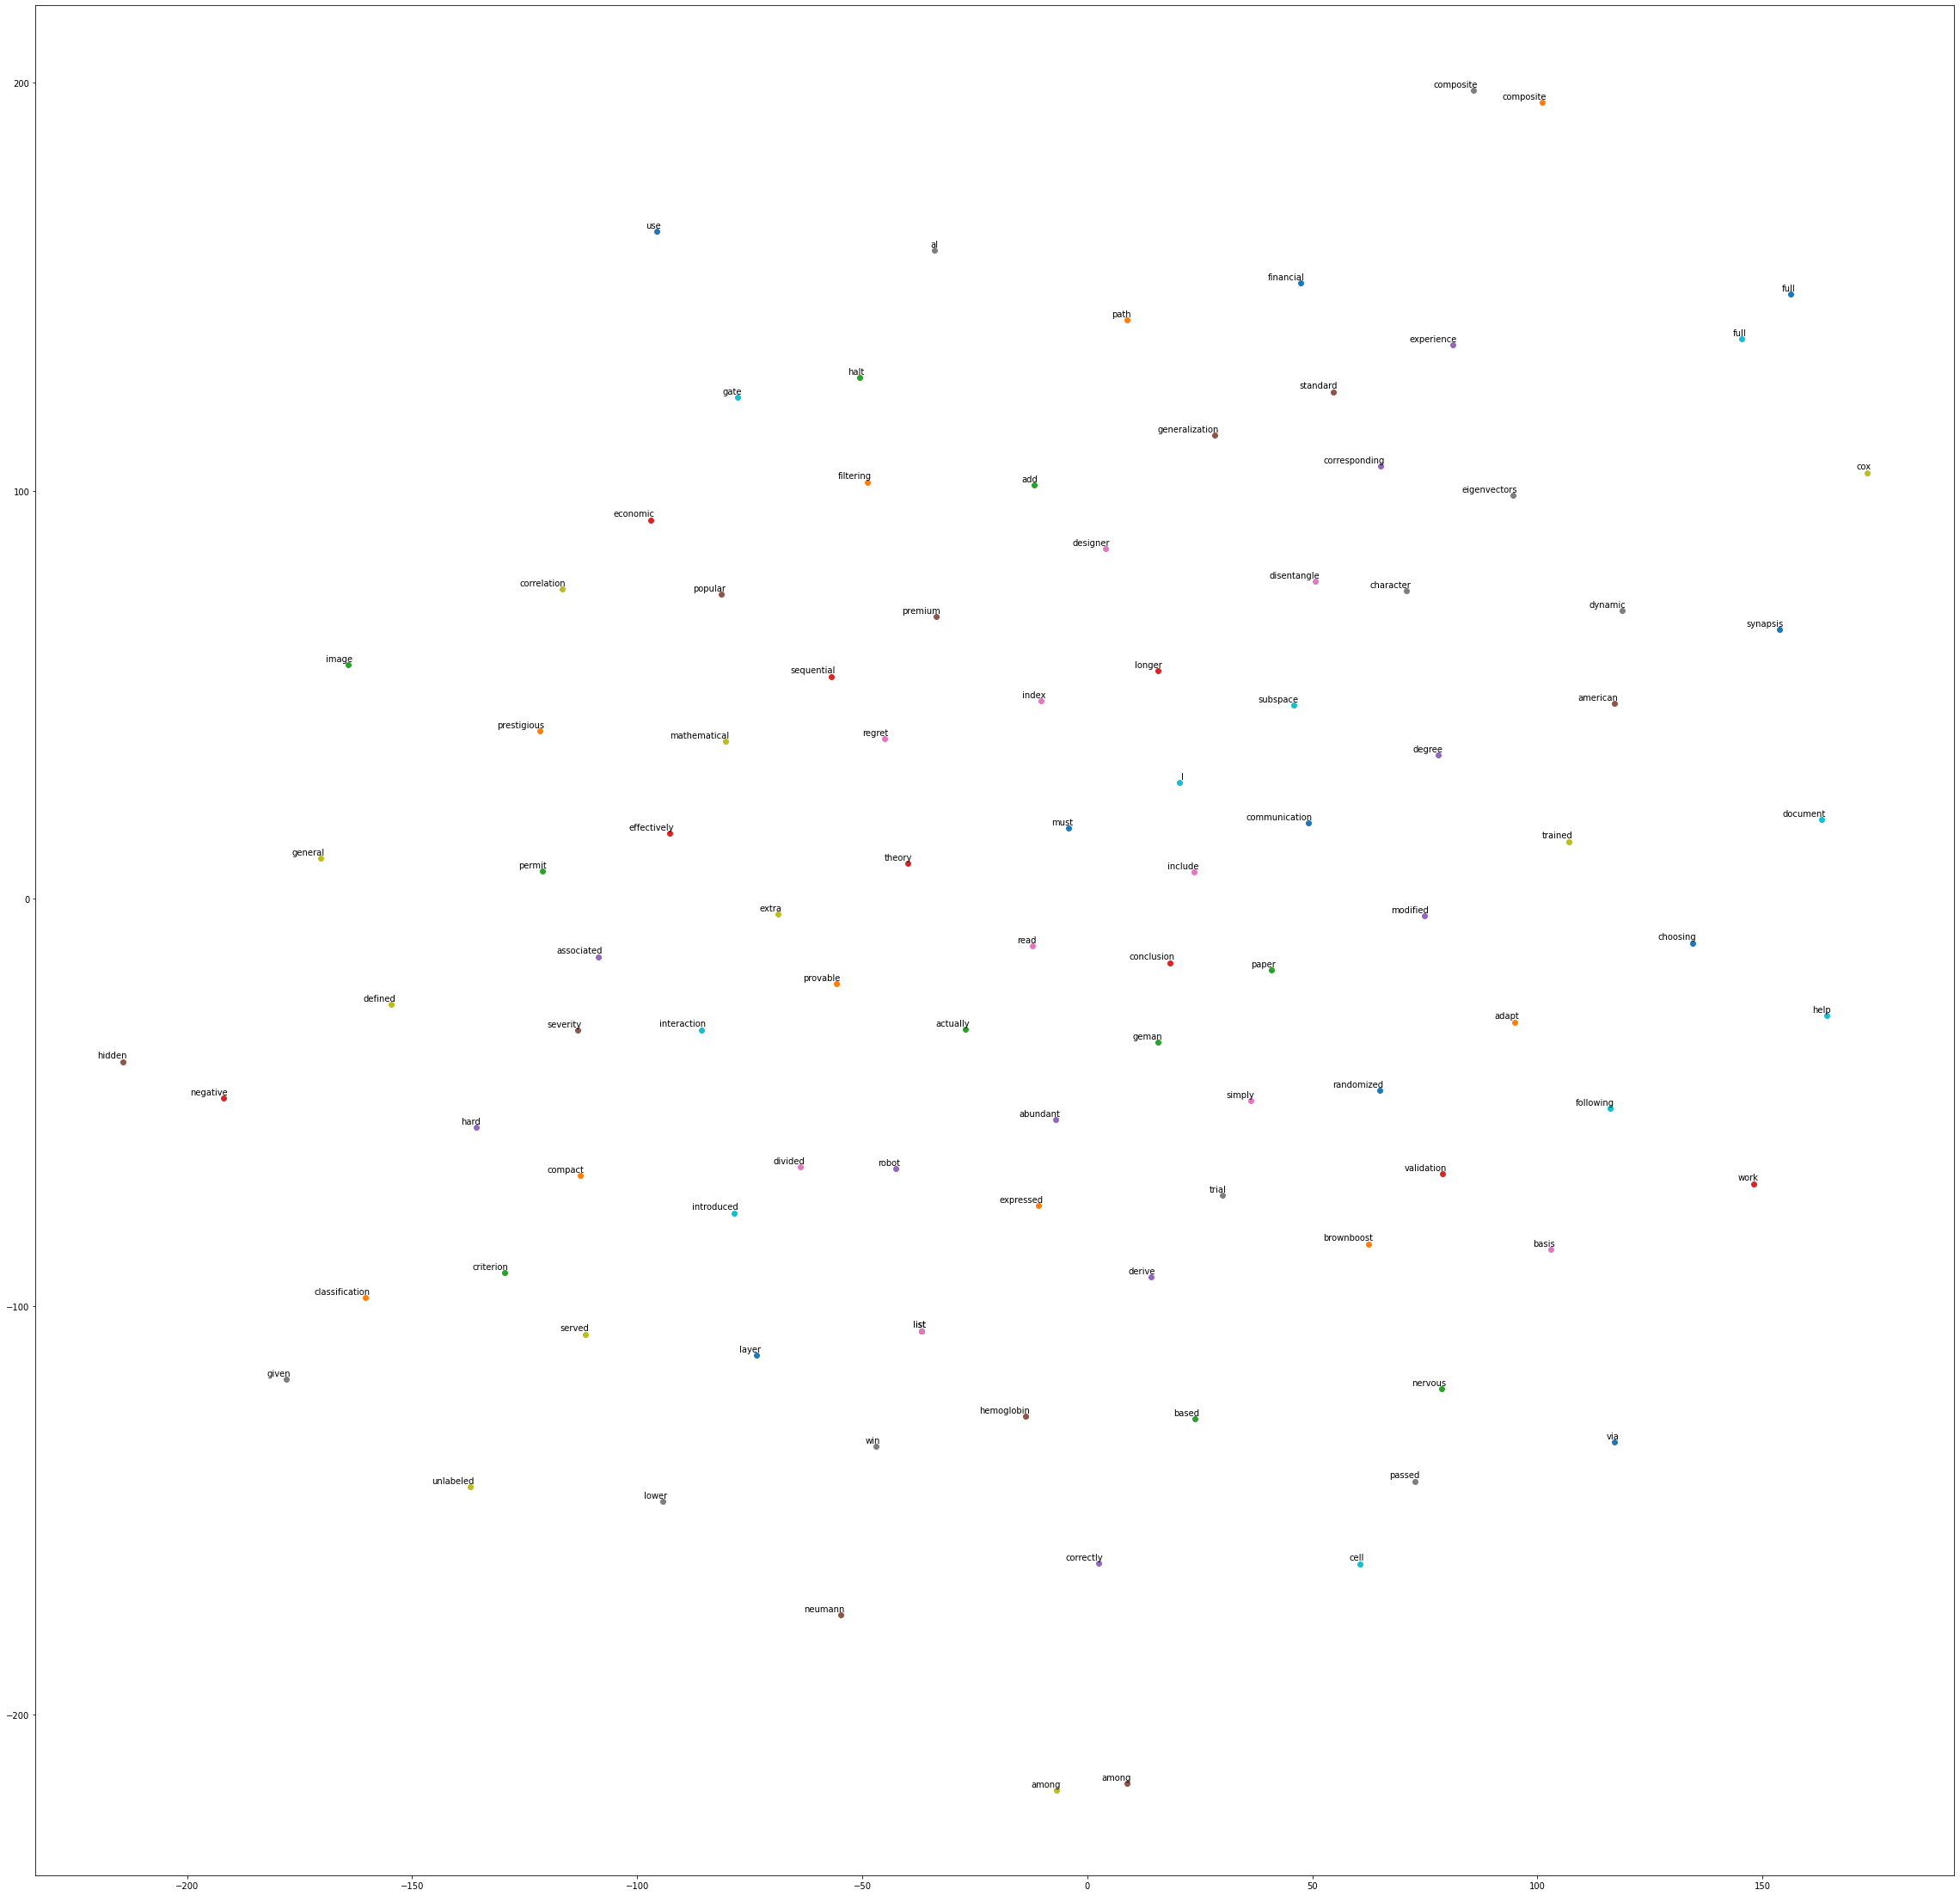

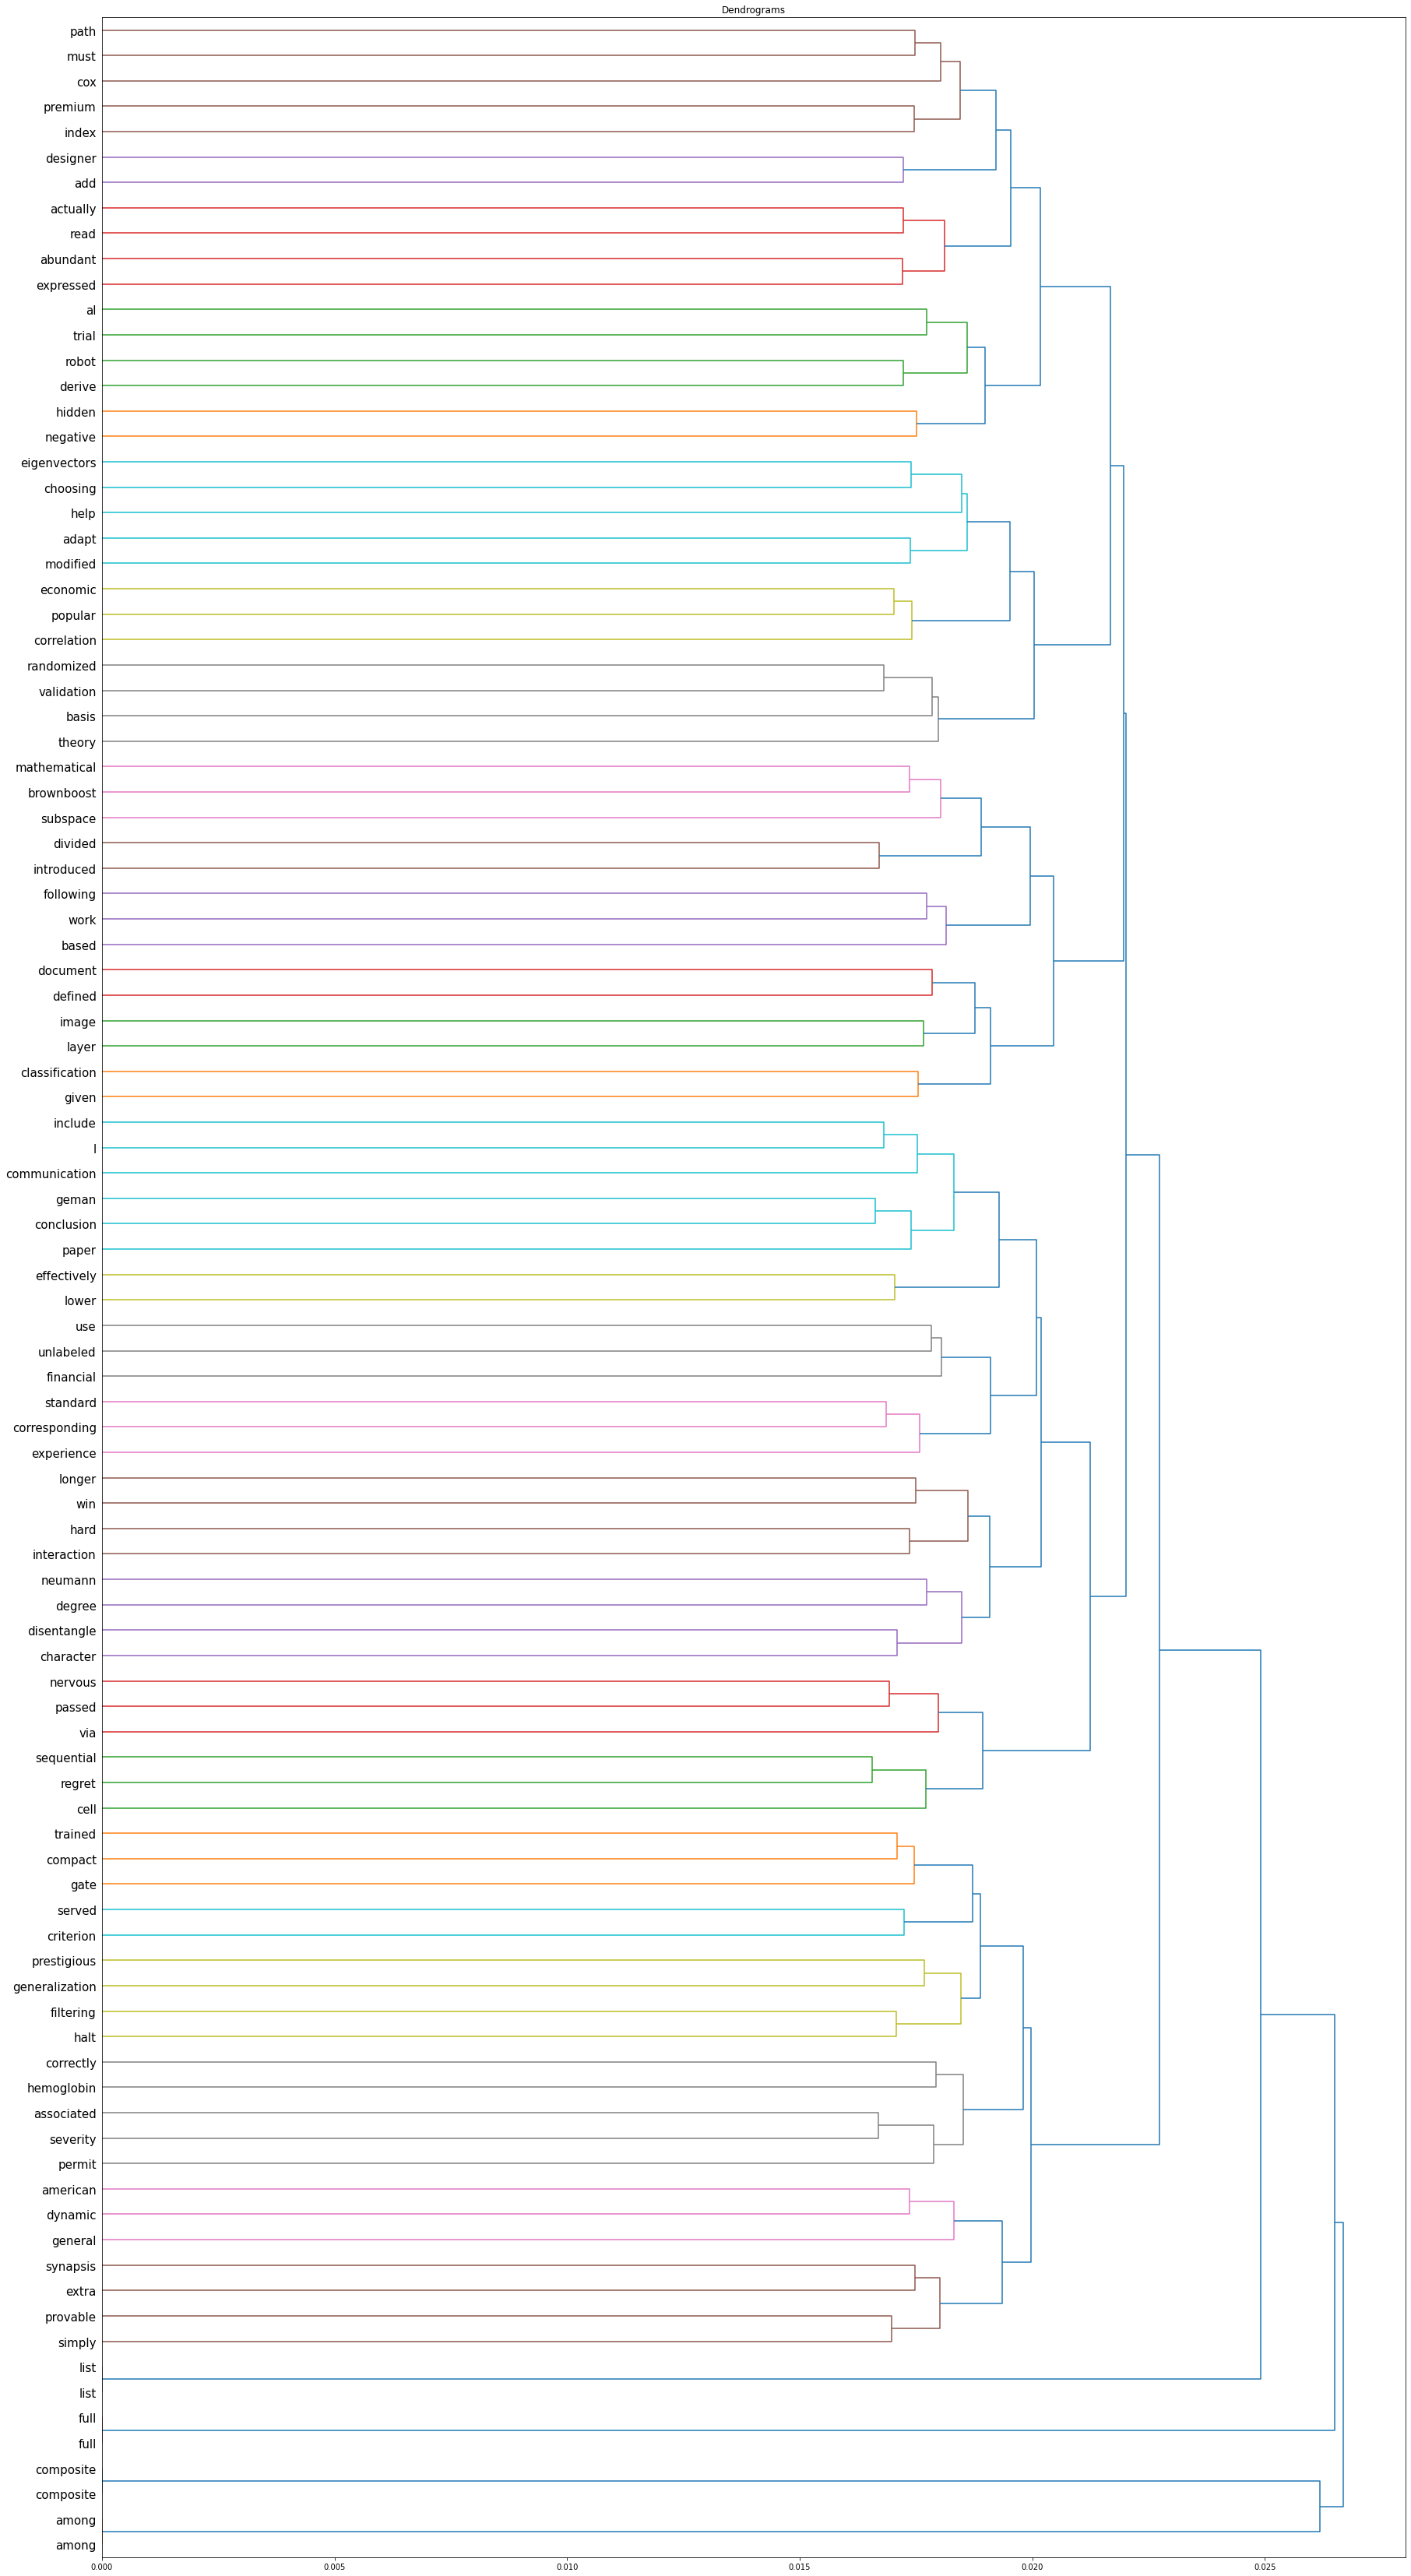

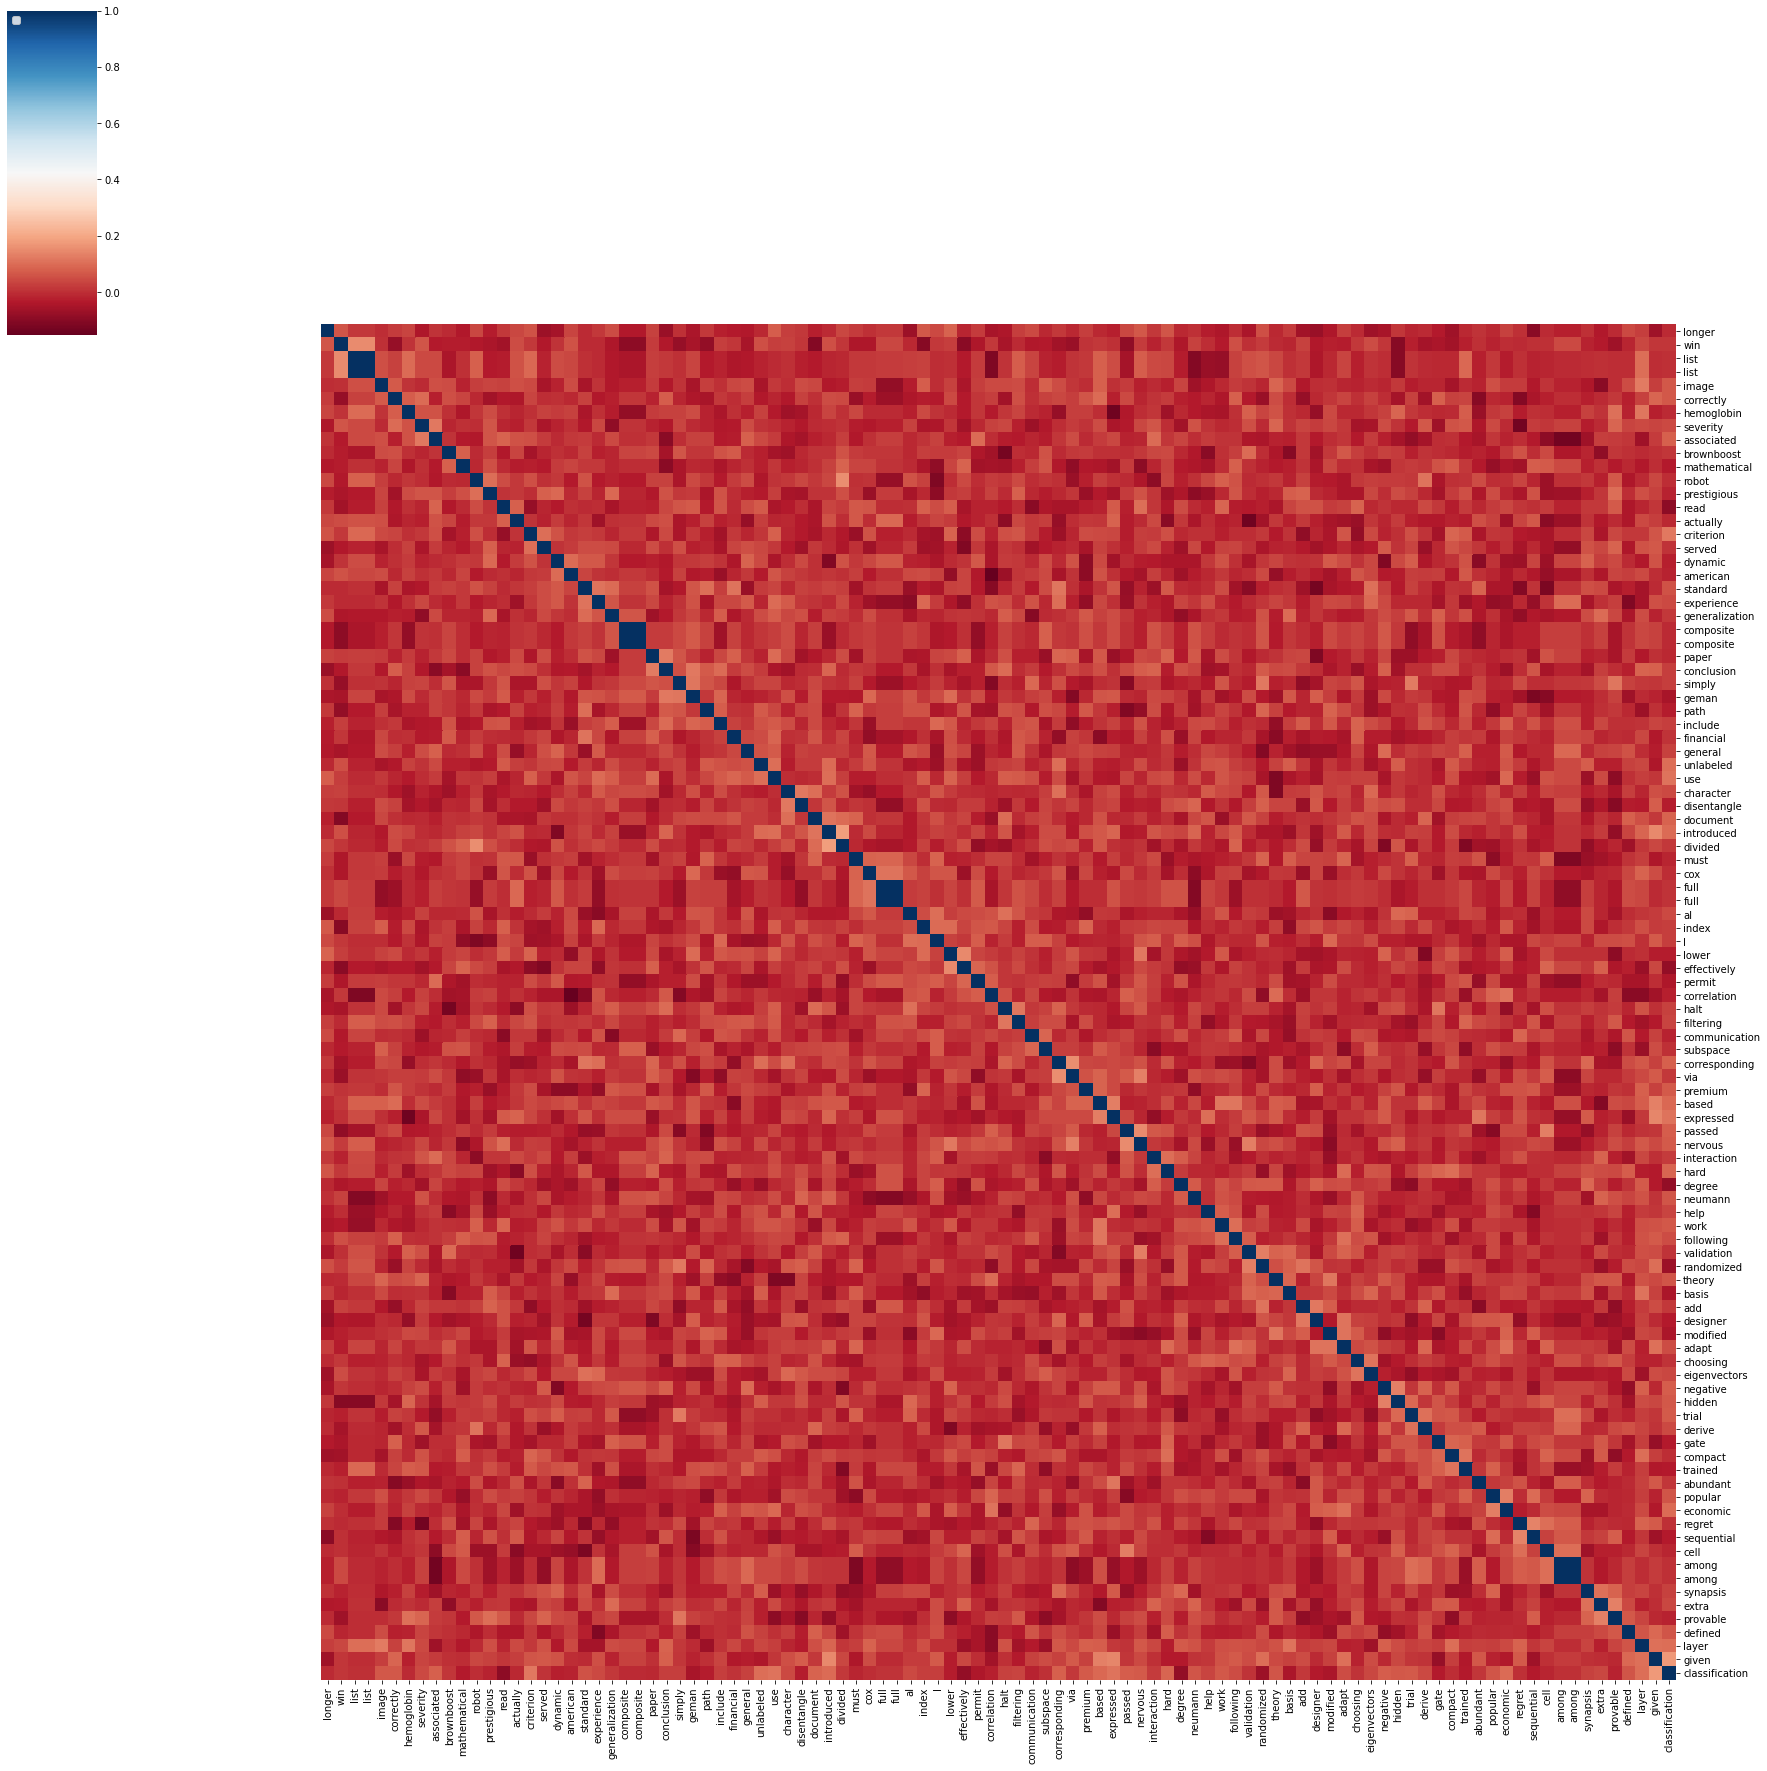

In [166]:
run_word2vec_experiment(documents, clean_baseline_method, 500, chosen_tokens, 'Word2Vec_exp')

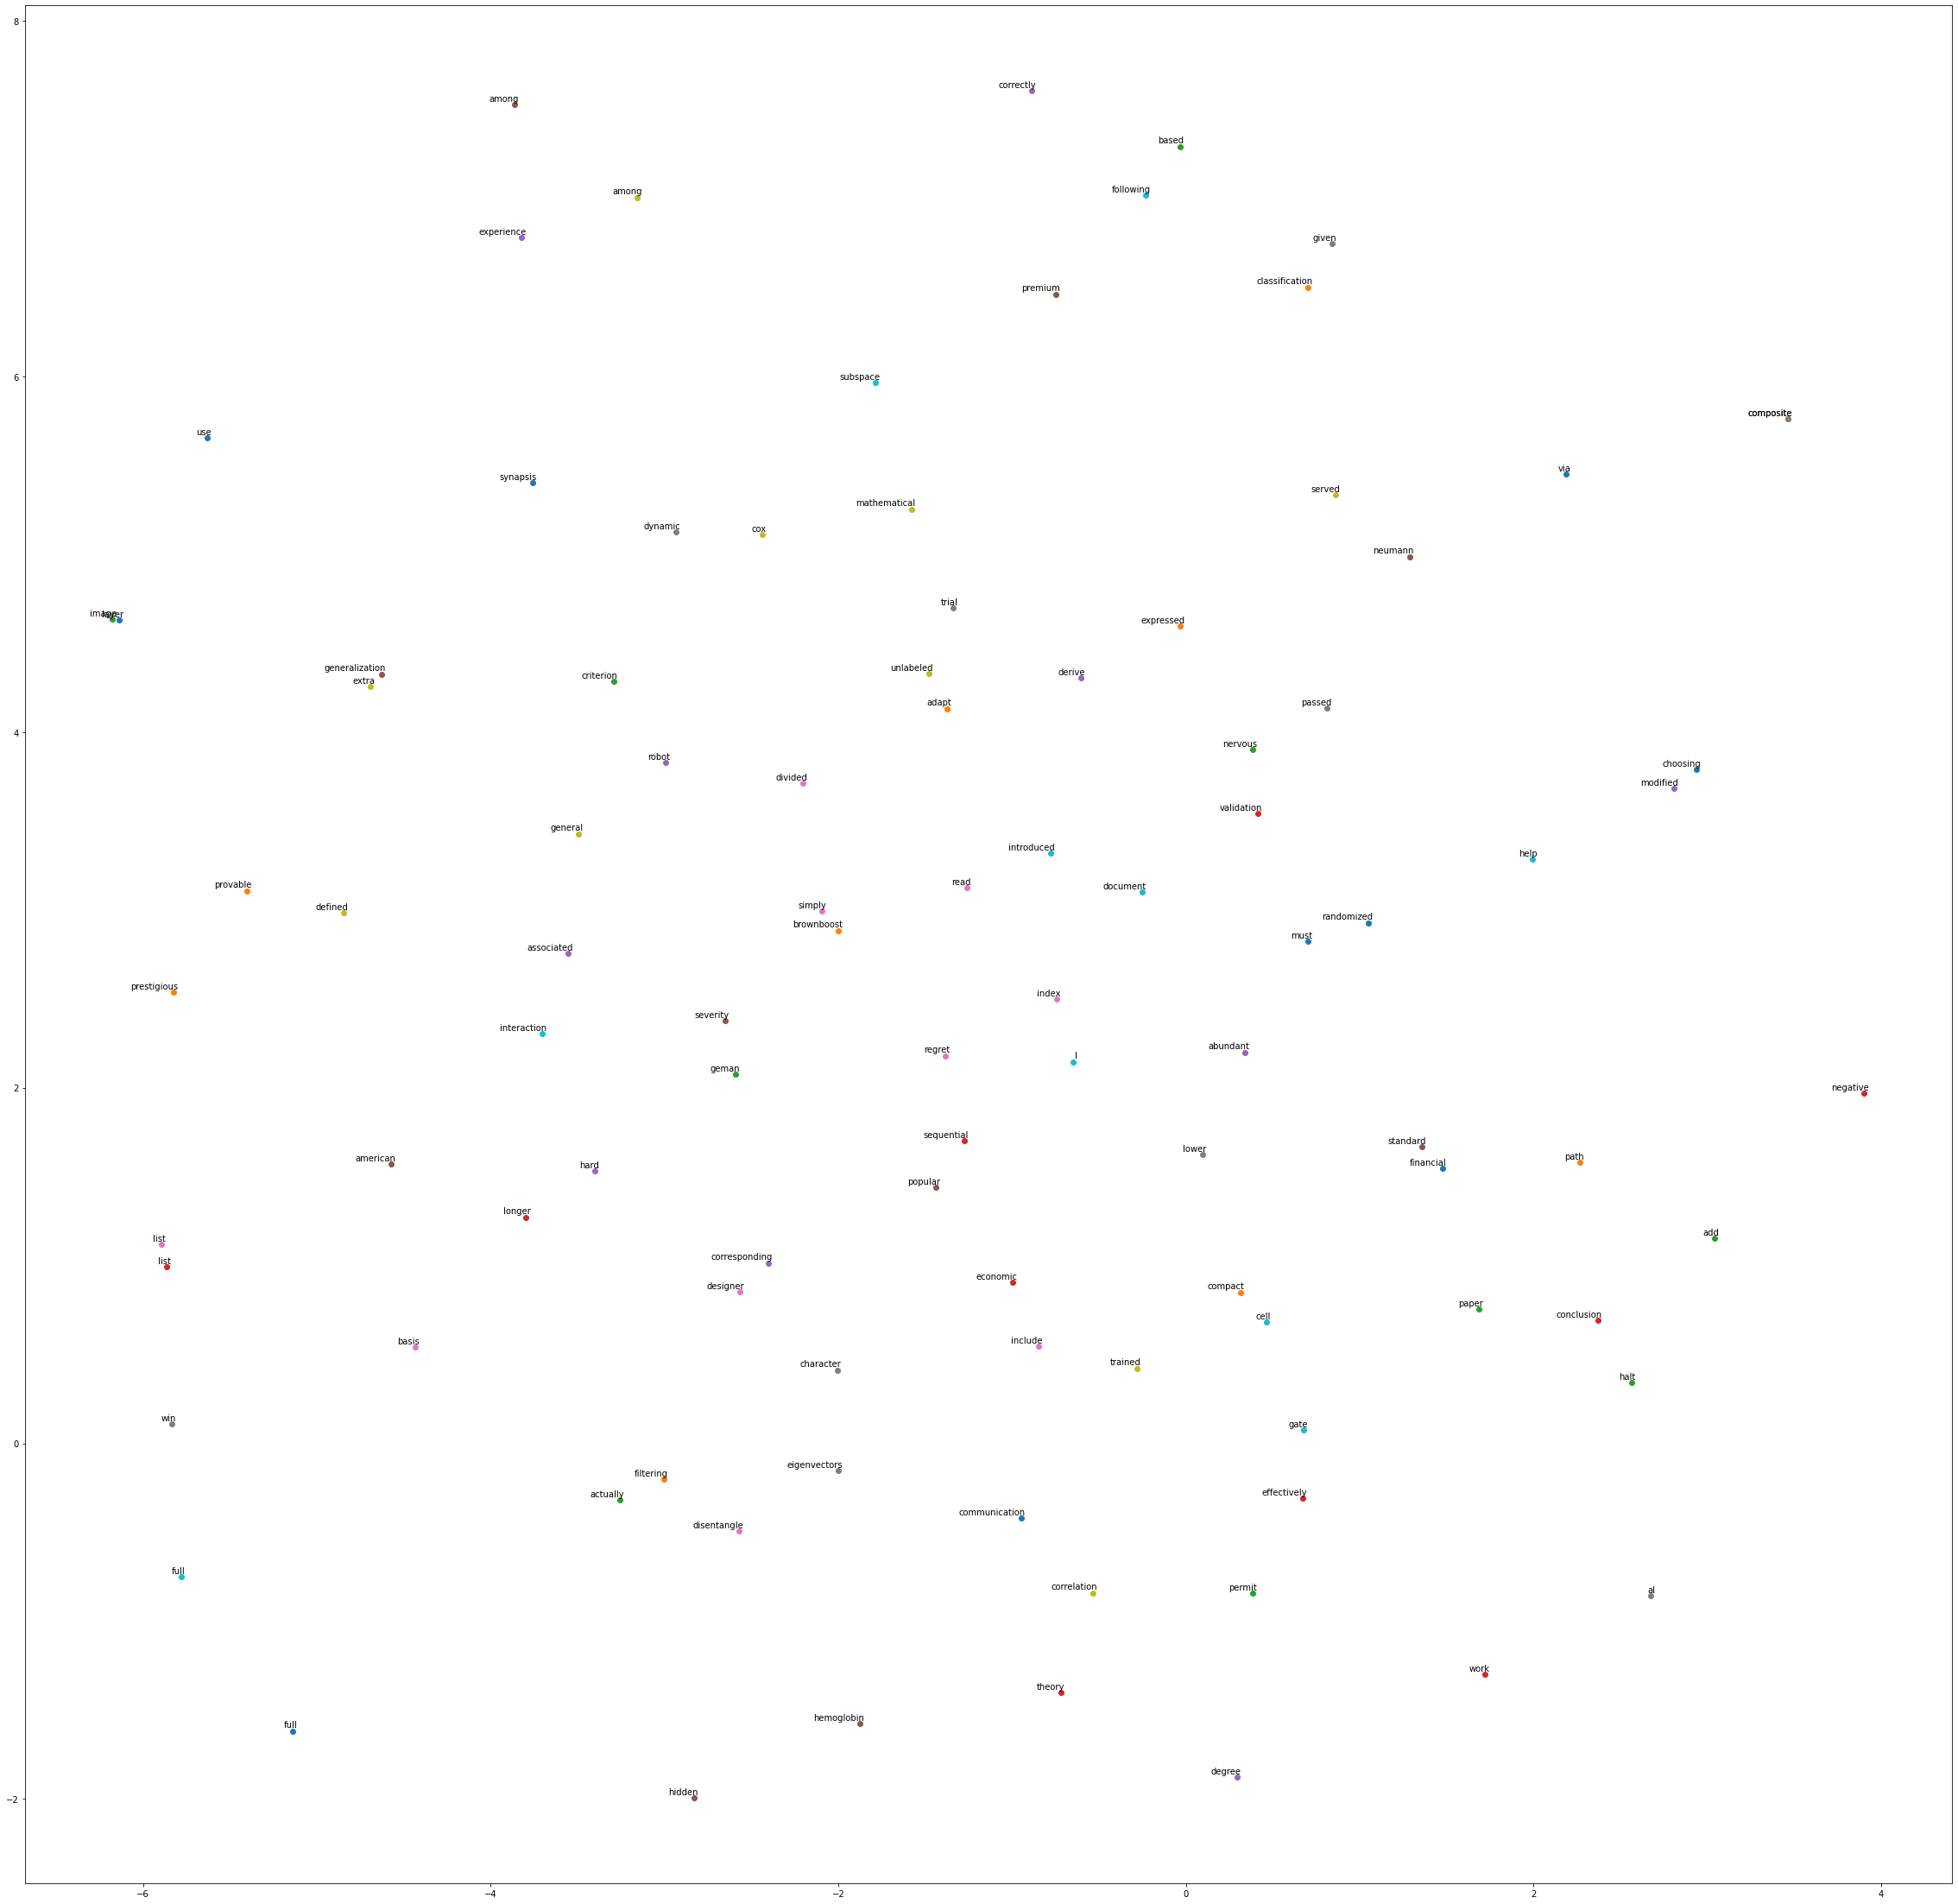

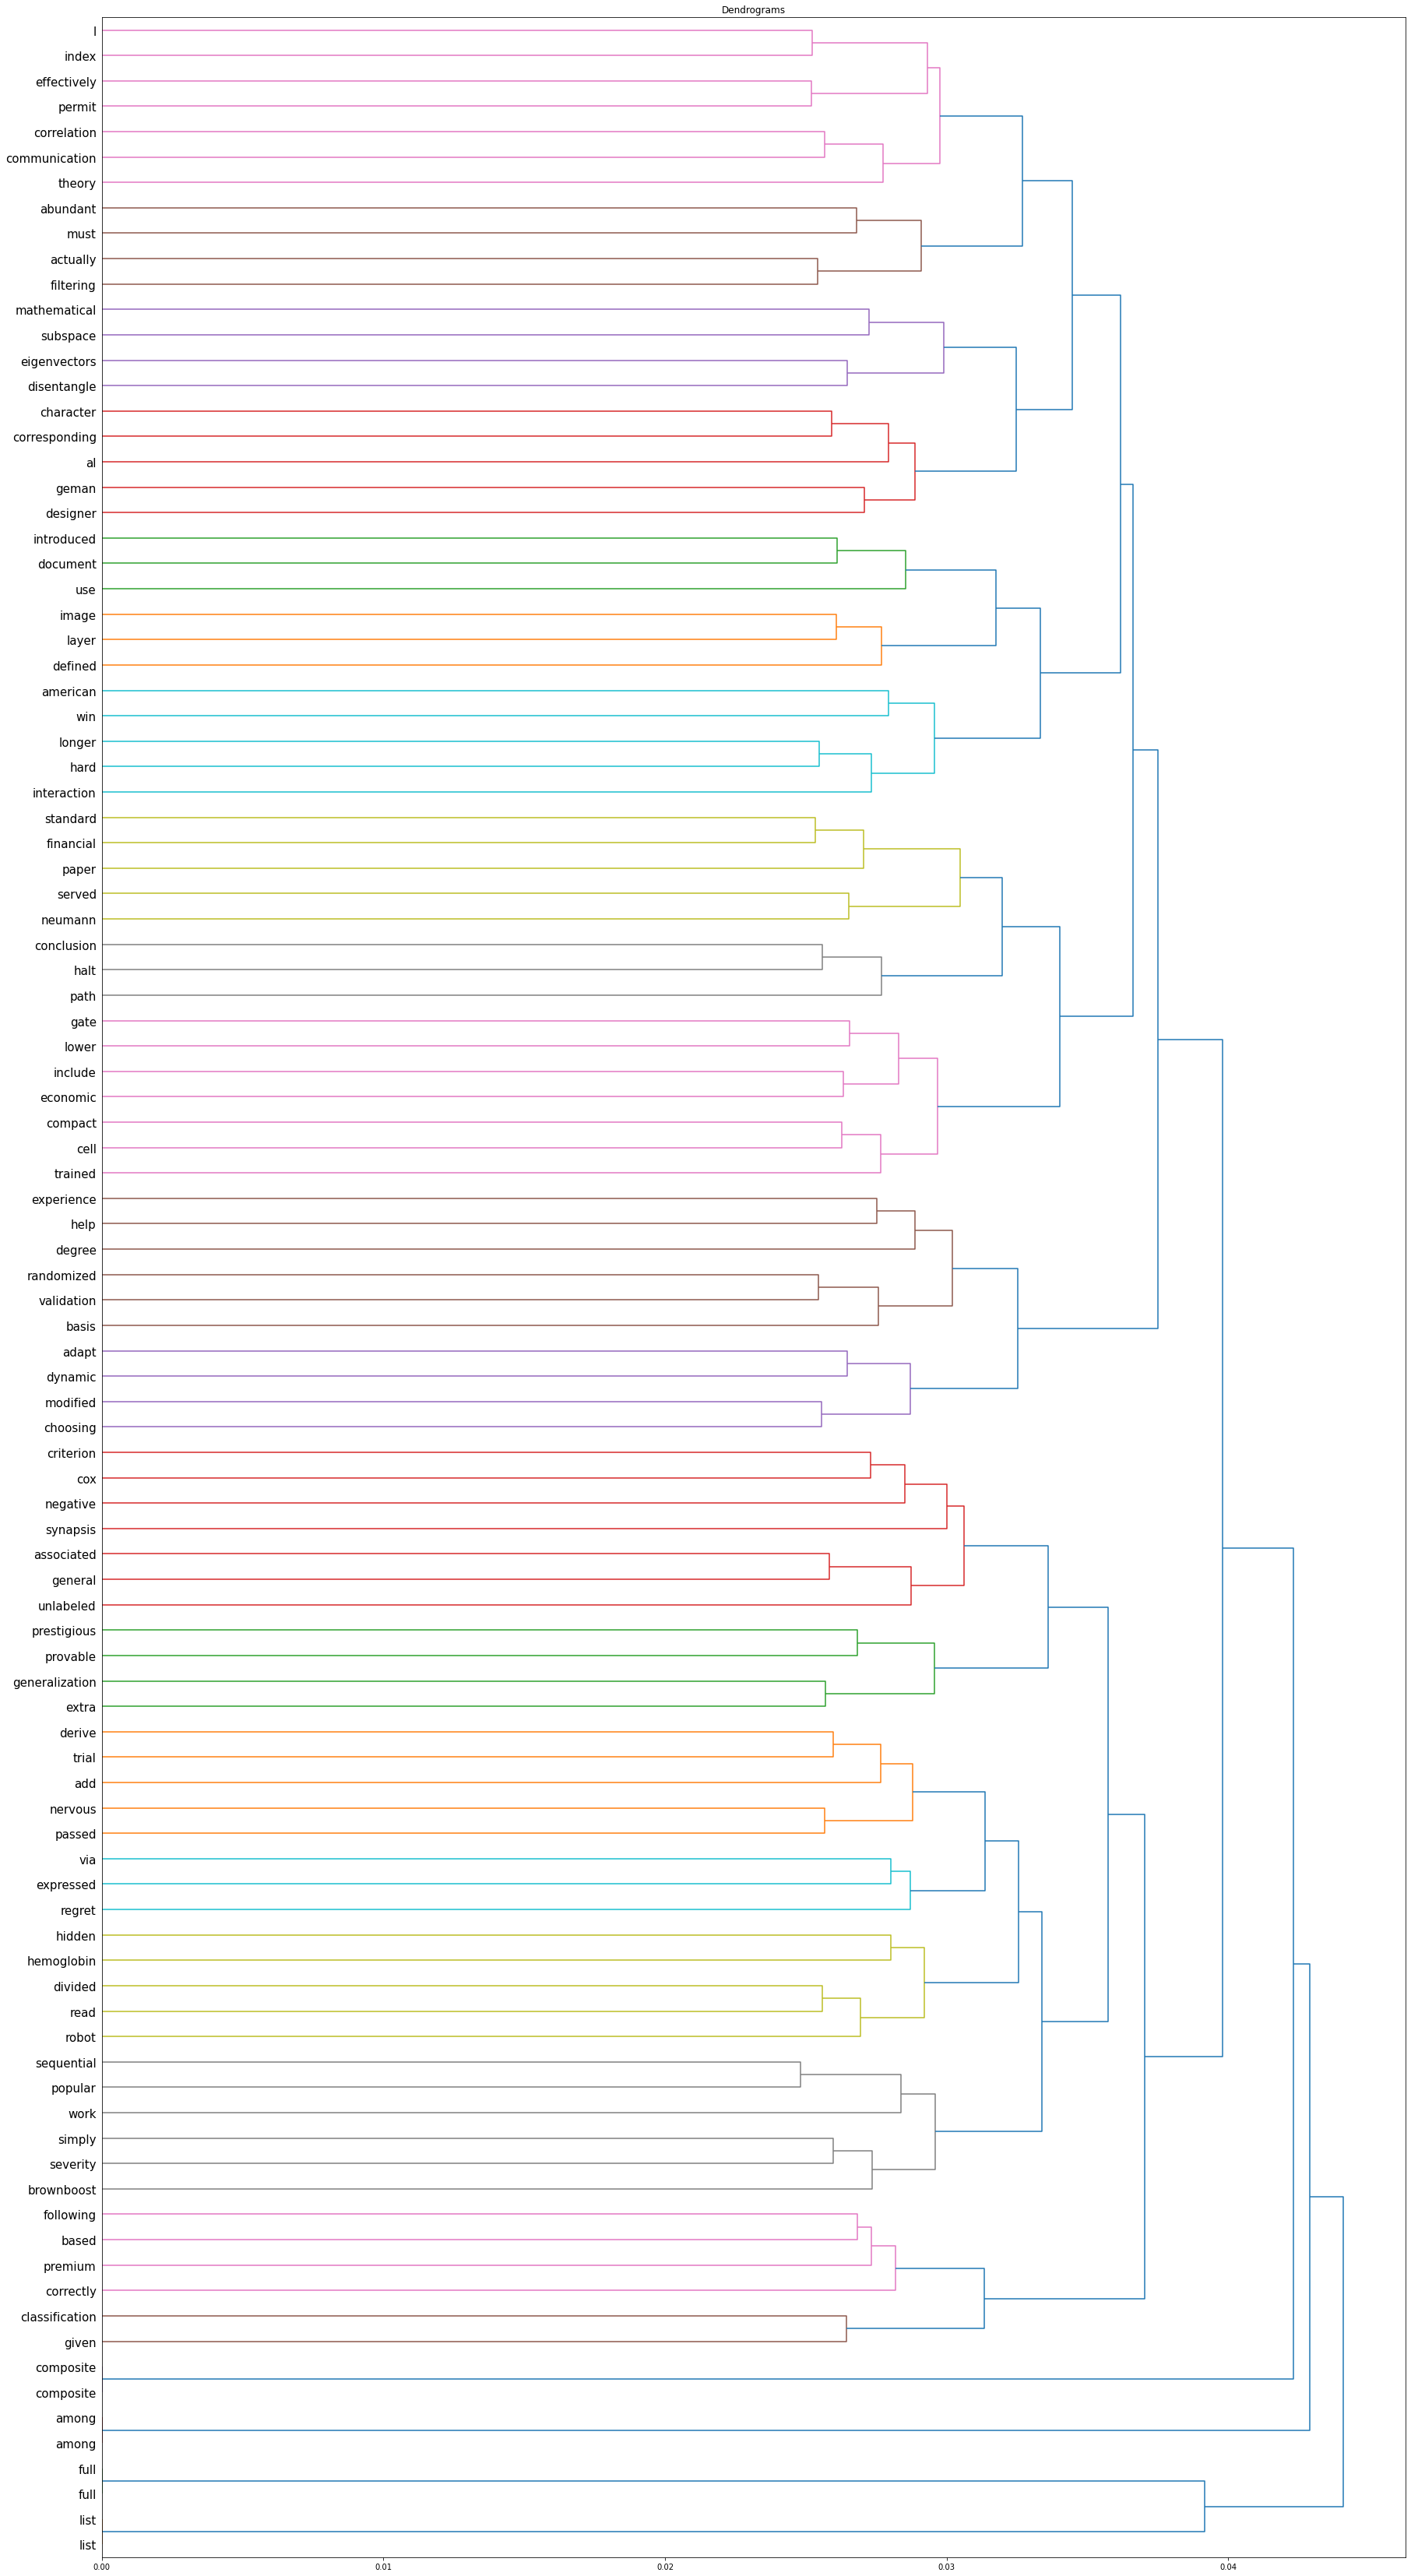

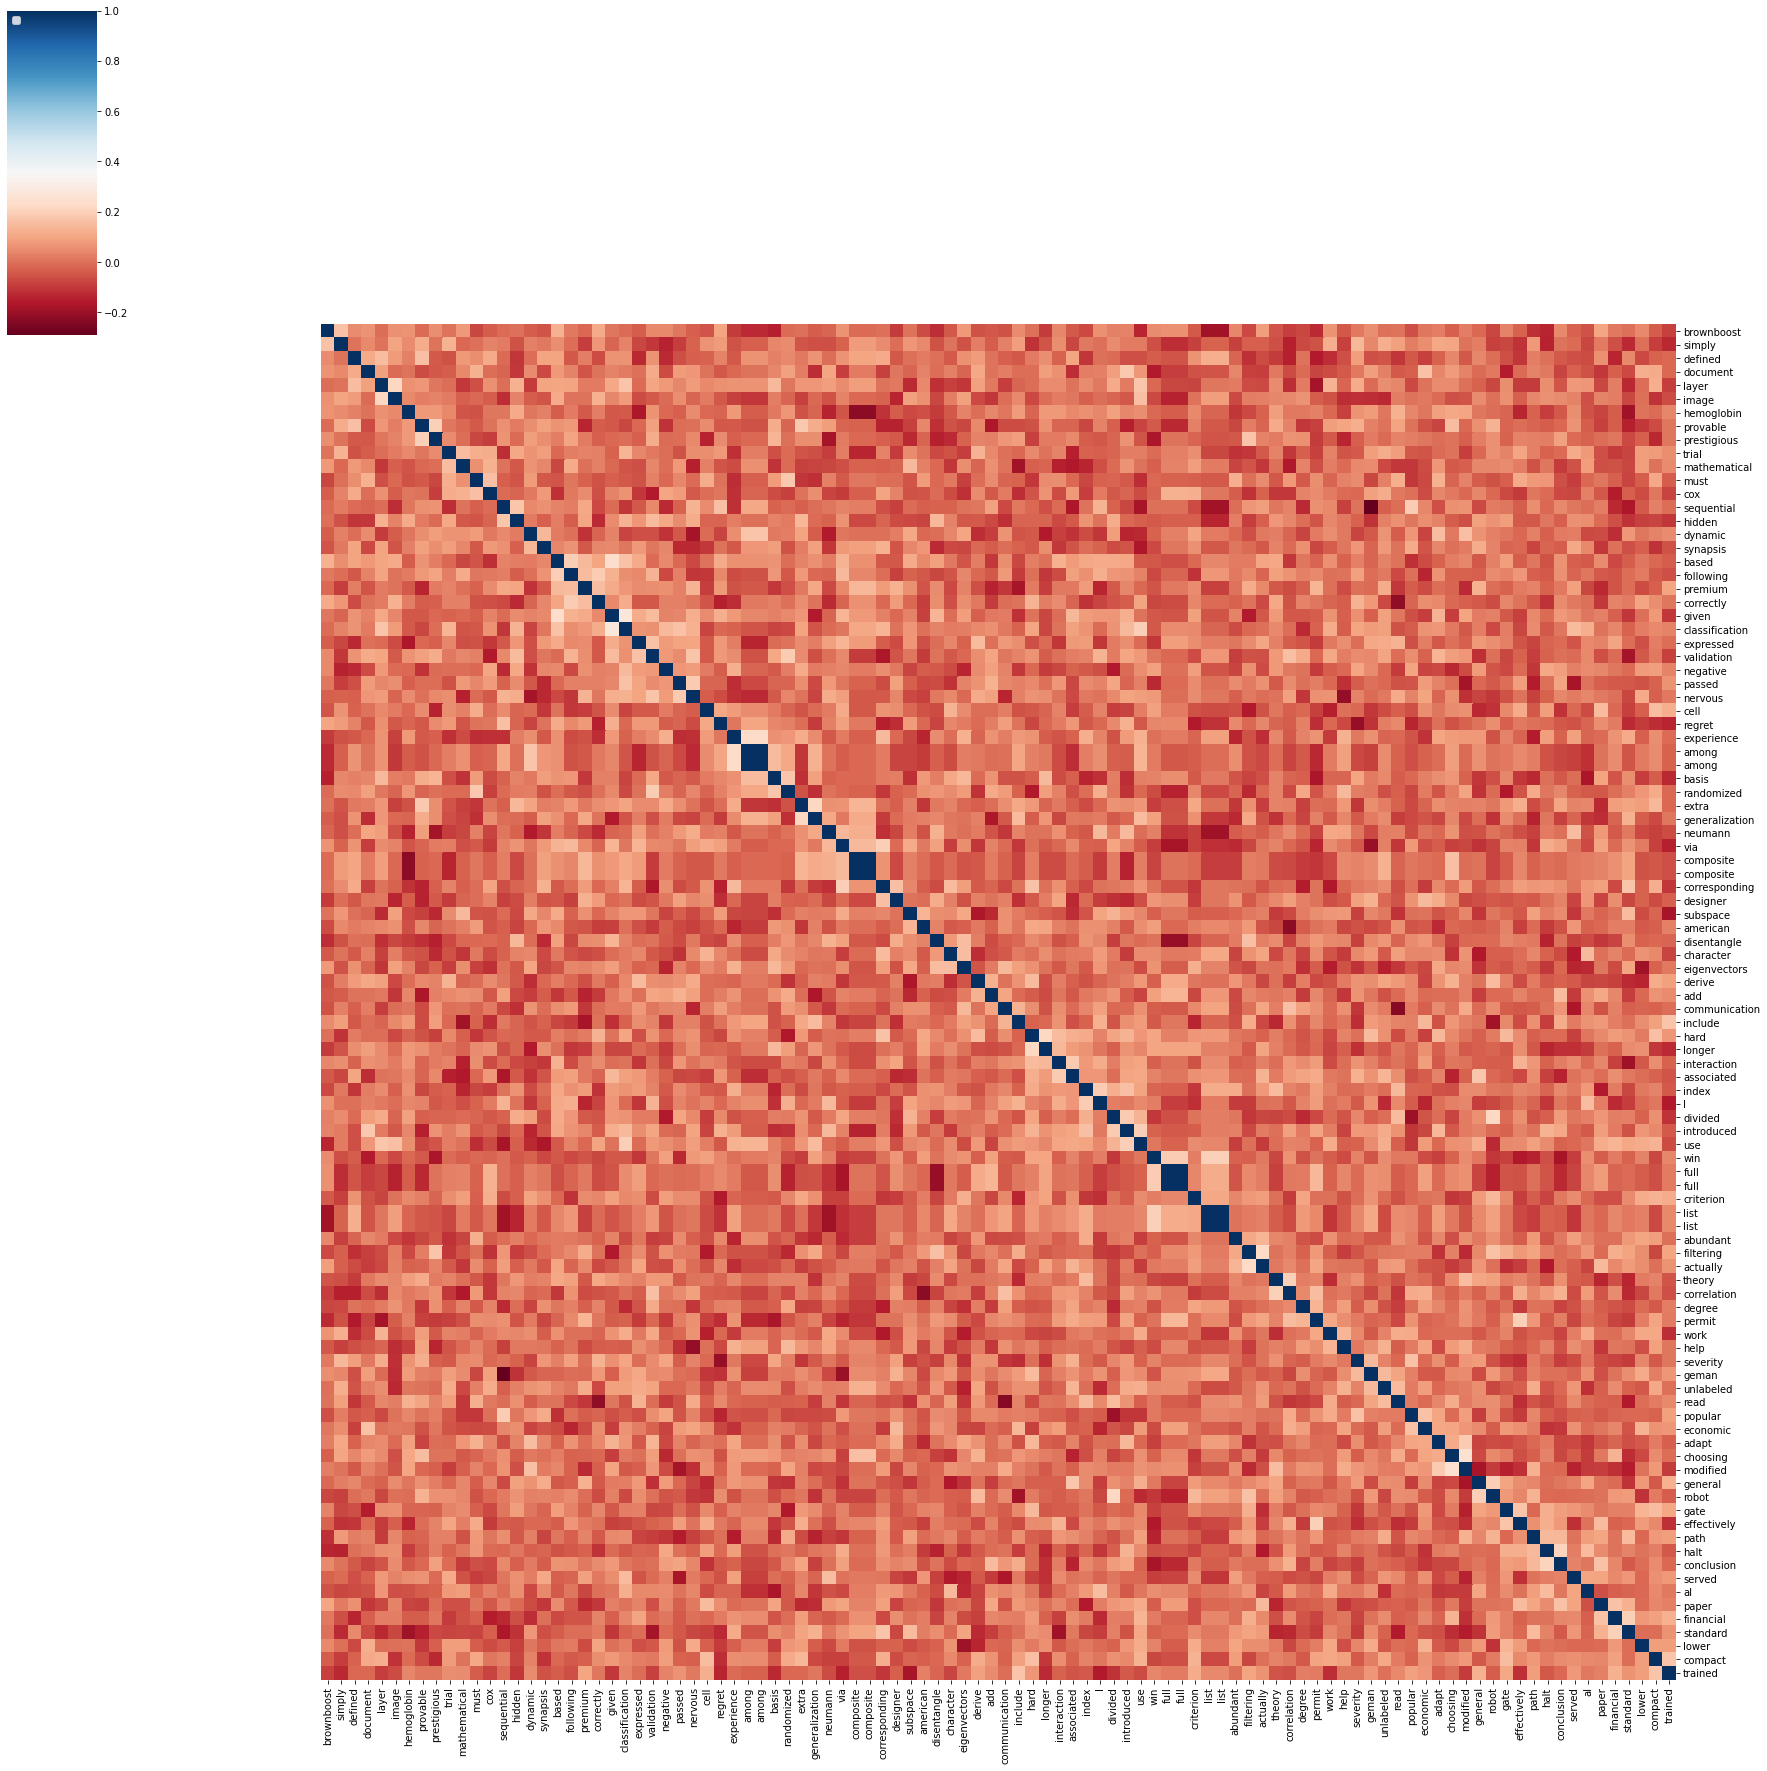

In [167]:
run_word2vec_experiment(documents, clean_baseline_method, 200, chosen_tokens, 'Word2Vec_exp')

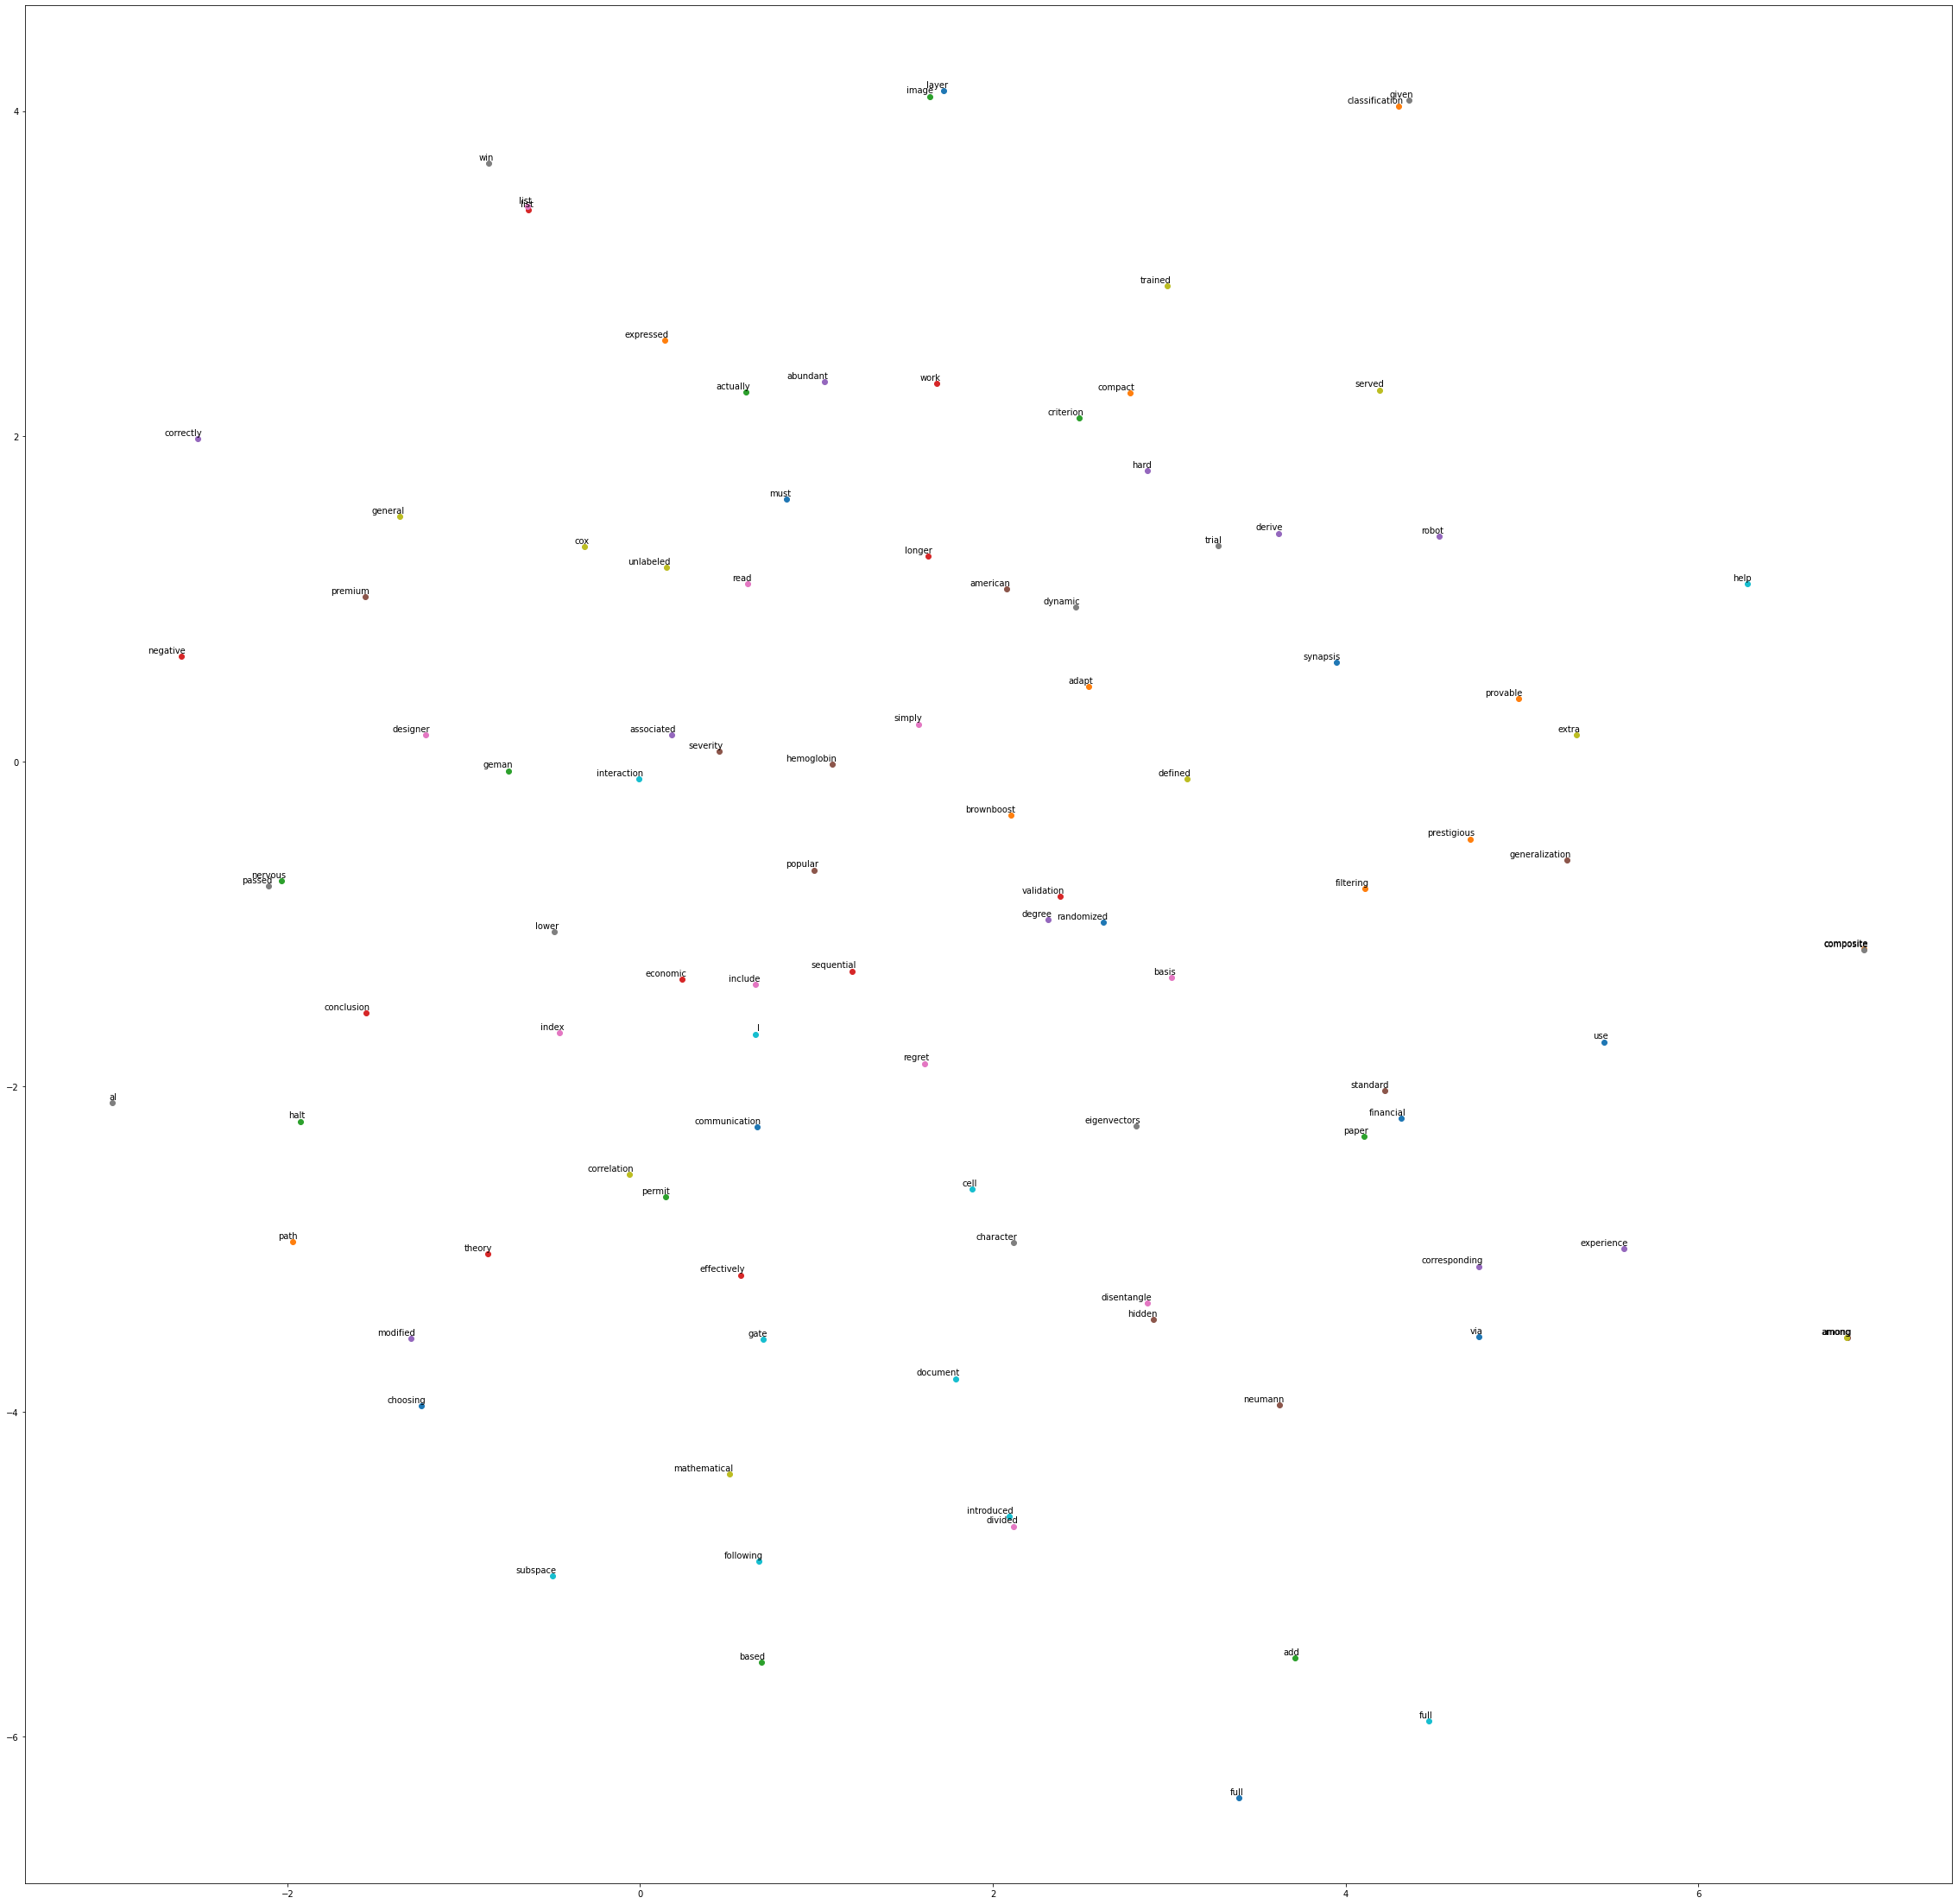

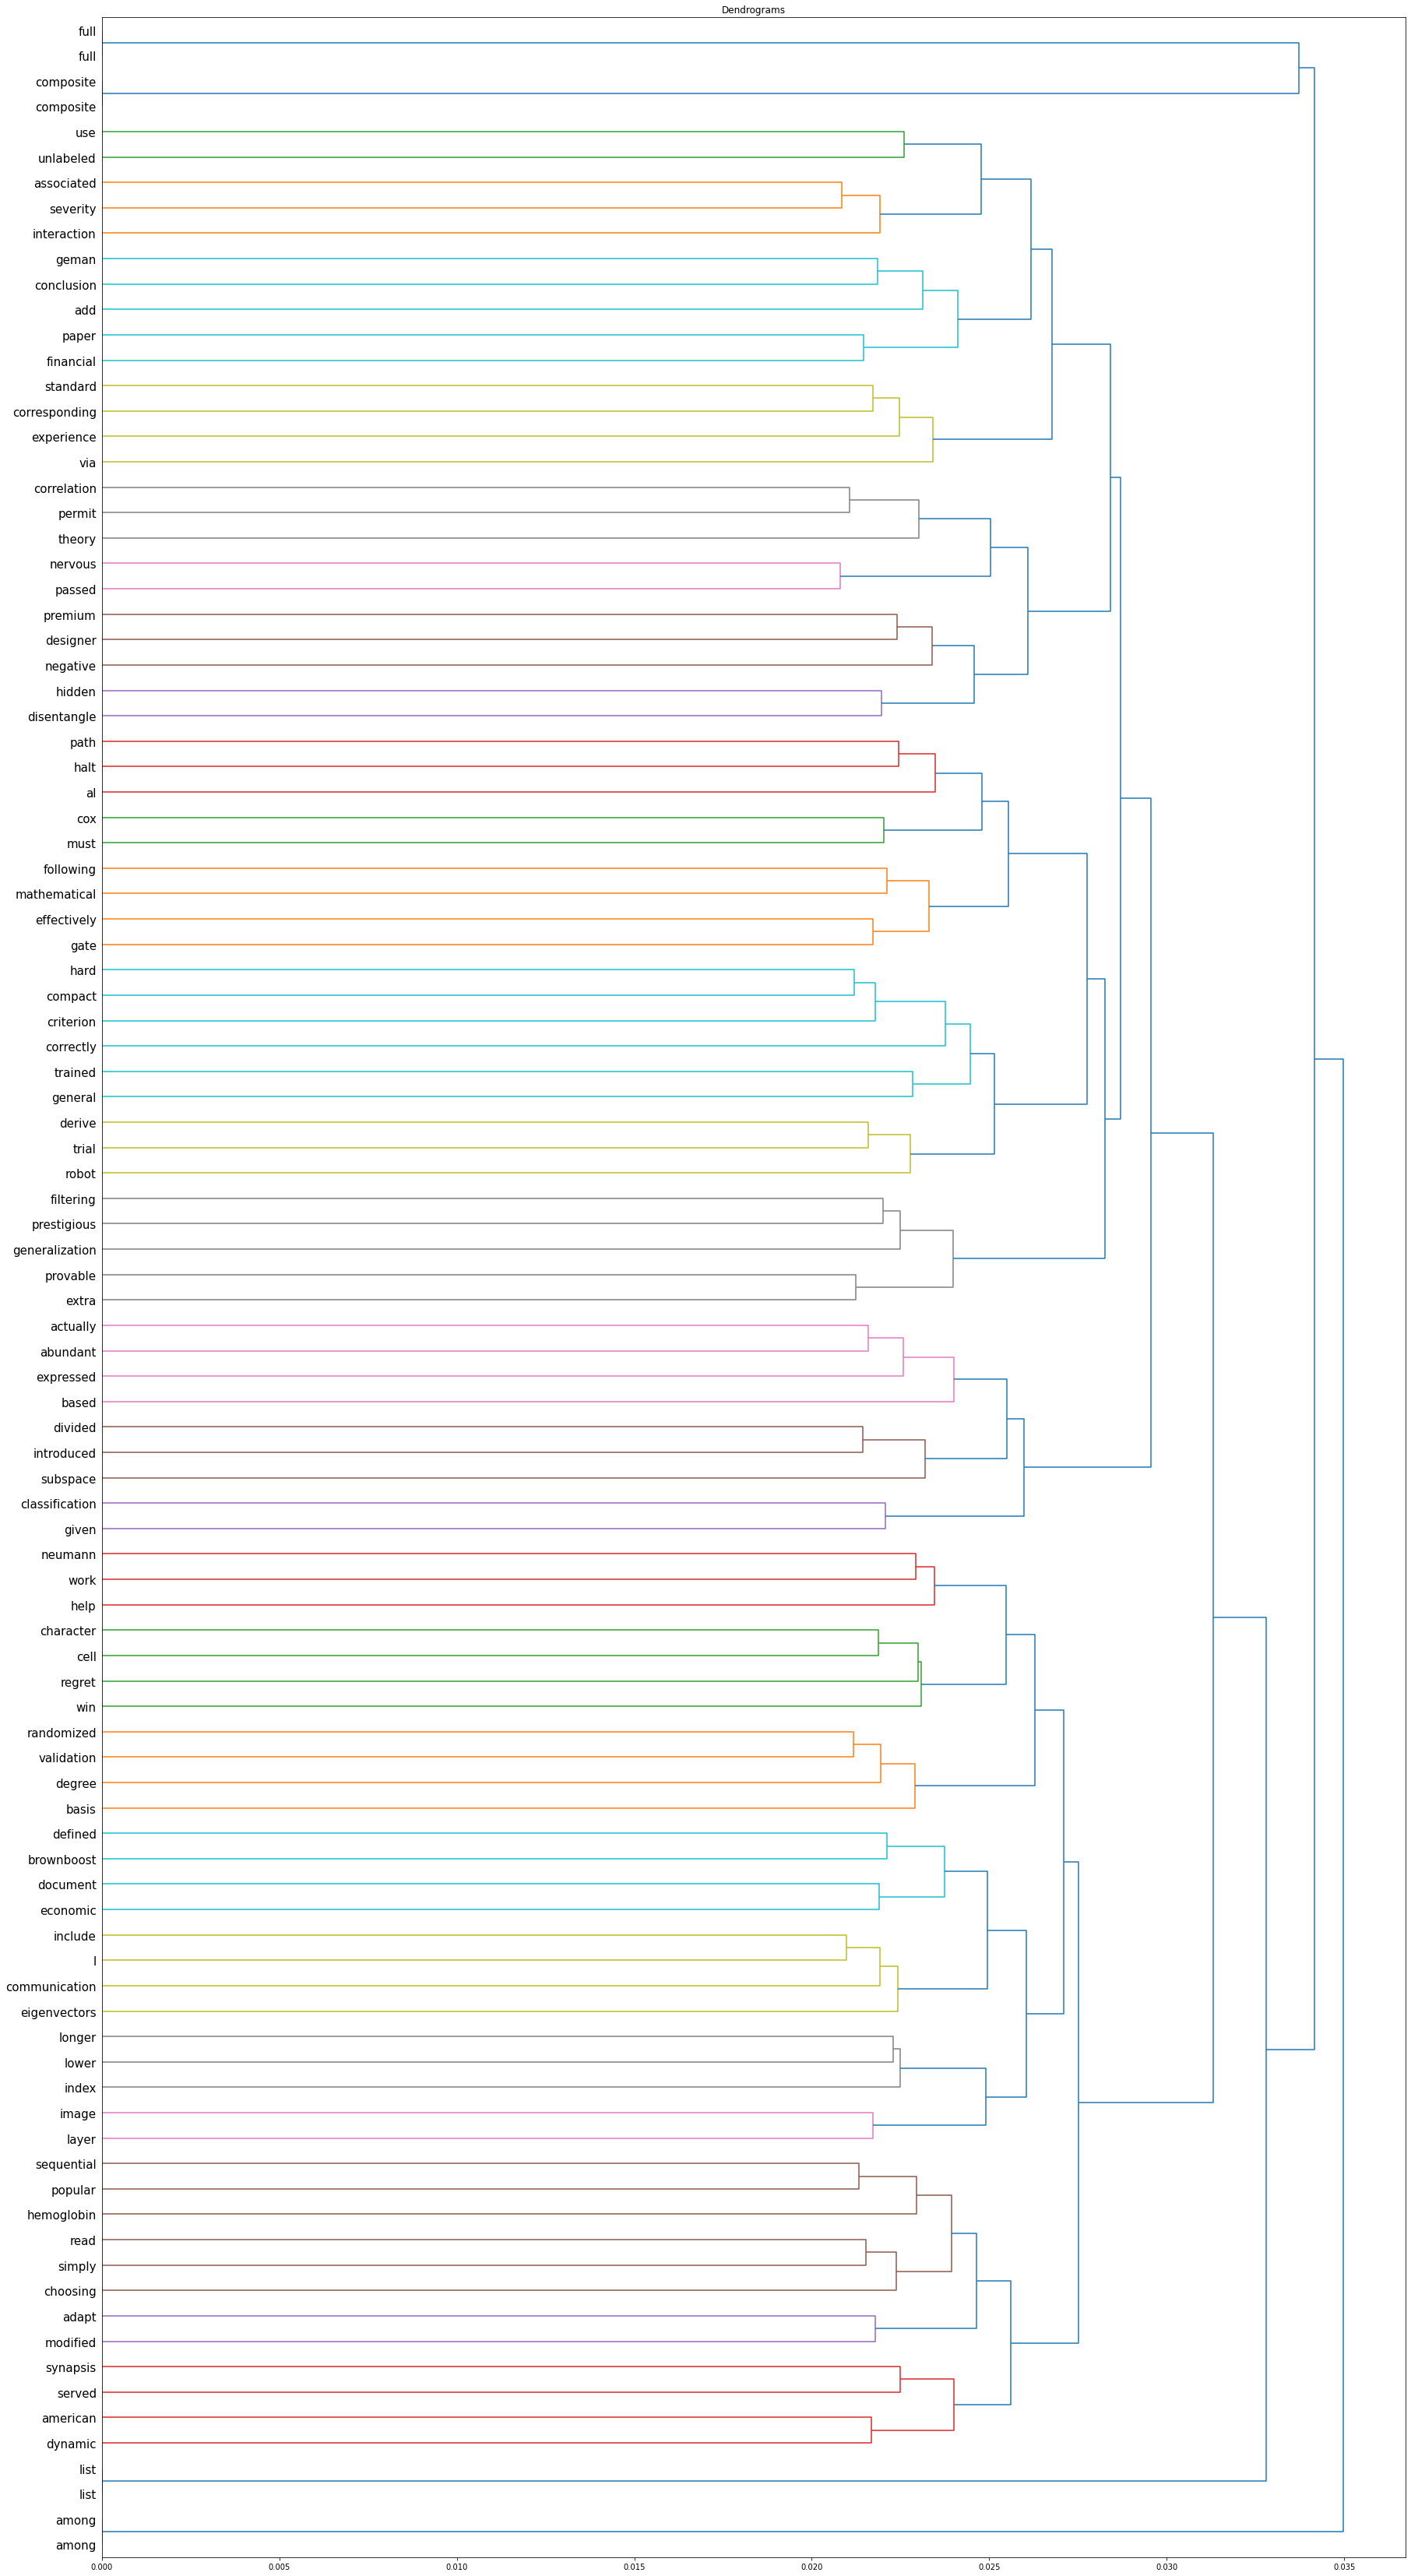

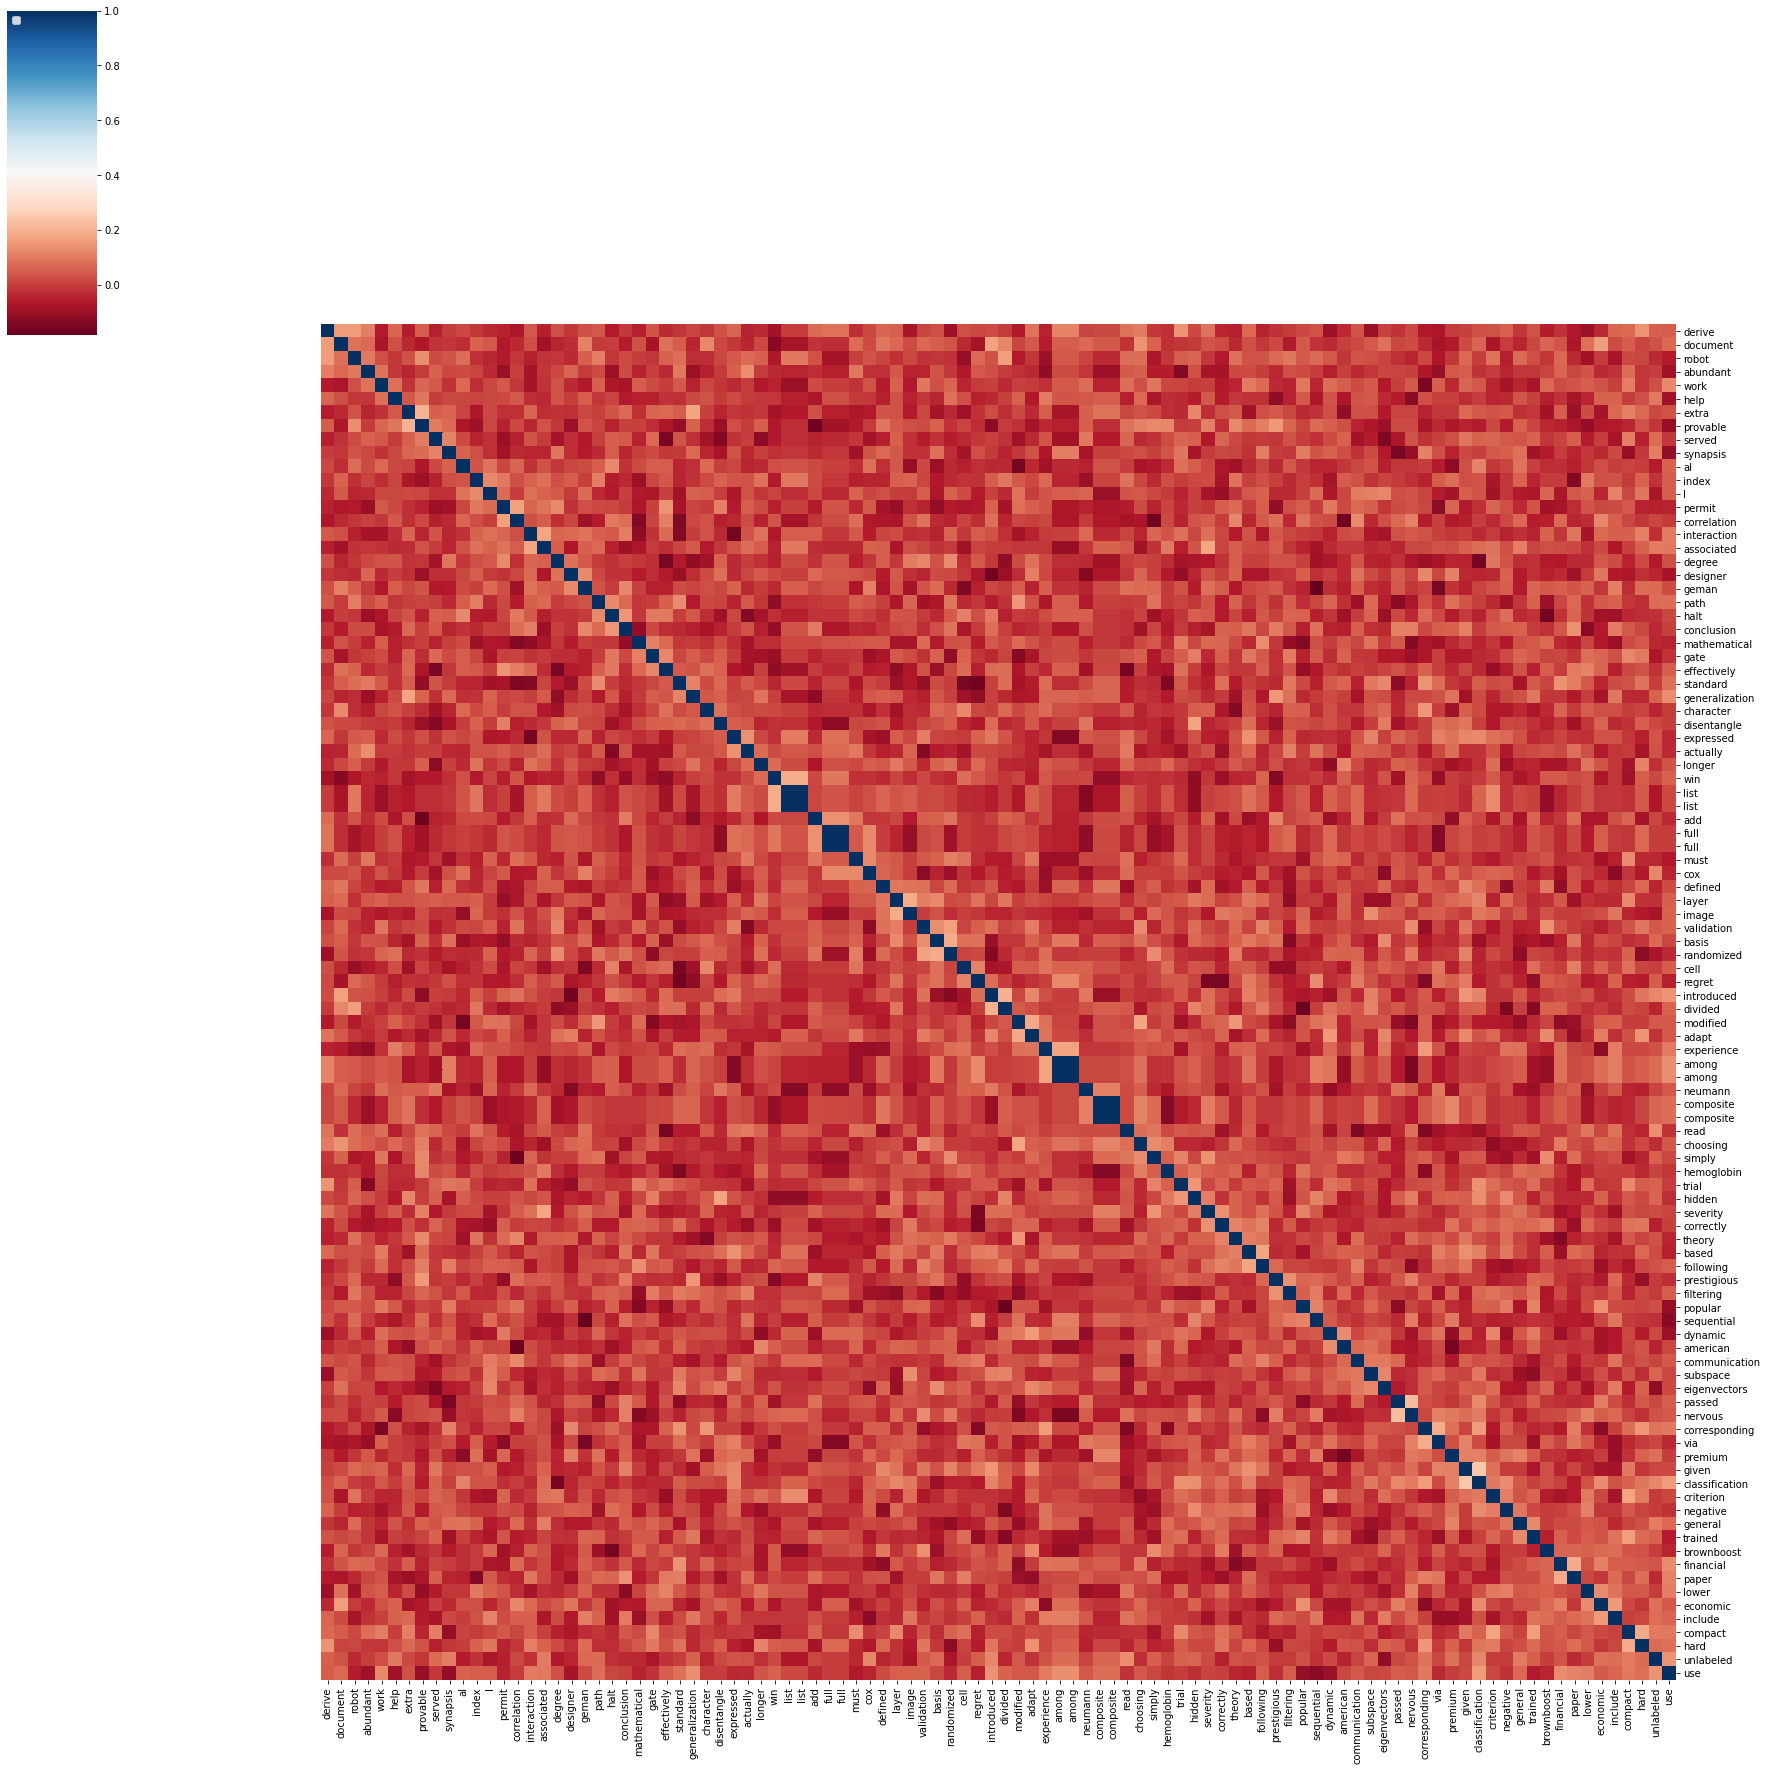

In [168]:
run_word2vec_experiment(documents, clean_baseline_method, 300, chosen_tokens, 'Word2Vec_exp')

In [169]:
# !python3 -m spacy download en_core_web_lg
import en_core_web_sm
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 
nlp = spacy.load('en_core_web_lg')

In [170]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
1                                         [hello, help]
10    [machine, learning, problem, unsupervised, lea...
11    [k, mean, clustering, method, vector, quantiza...
12    [principal, component, analysis, pca, statisti...
13    [decision, tree, learning, use, decision, tree...
Name: lemmas, dtype: object

In [171]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

corpus_df['lemmas_joined'].head()
corpus_df.head(3).T

Doc_ID,1,10,11
DSI_Title,Doc1,Doc10,Doc11
Student Name,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...
Descriptor,1,10,11
Doc_ID,1,10,11
lemmas,"[hello, help]","[machine, learning, problem, unsupervised, lea...","[k, mean, clustering, method, vector, quantiza..."
lemmas_joined,hello help,machine learning problem unsupervised learning...,k mean clustering method vector quantization o...


In [172]:
vectorizer = CountVectorizer(ngram_range=(1, 6))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 6), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 17949
Curated Vocabulary size: 100


In [173]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
1                                                    []
10    [machine, learning, problem, learning, structu...
11    [k, mean, method, vector, signal, processing, ...
12    [analysis, set, observation, variable, set, va...
13    [decision, tree, learning, decision, tree, mod...
Name: lemmas, dtype: object

# KG

In [174]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

# Entity Extraction function

In [175]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions# 

In [176]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [177]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,1,10,11
DSI_Title,Doc1,Doc10,Doc11
Student Name,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...
Descriptor,1,10,11
Doc_ID,1,10,11
lemmas,[],"[machine, learning, problem, learning, structu...","[k, mean, method, vector, signal, processing, ..."
lemmas_joined,,machine learning problem learning structure da...,k mean method vector signal processing analysi...
raw_sentences,"[Hello!, how can i help you ?]","[In machine learning, the problem of unsupervi...",[k-means clustering is a method of vector quan...


In [178]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
1                                         [hello, help]
10    [machine, learning, problem, unsupervised, lea...
11    [k, mean, clustering, method, vector, quantiza...
12    [principal, component, analysis, pca, statisti...
13    [decision, tree, learning, use, decision, tree...
Name: lemmas, dtype: object

In [179]:
corpus_df.head(3).T

Doc_ID,1,10,11
DSI_Title,Doc1,Doc10,Doc11
Student Name,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...
Descriptor,1,10,11
Doc_ID,1,10,11
lemmas,"[hello, help]","[machine, learning, problem, unsupervised, lea...","[k, mean, clustering, method, vector, quantiza..."
lemmas_joined,,machine learning problem learning structure da...,k mean method vector signal processing analysi...
raw_sentences,"[Hello!, how can i help you ?]","[In machine learning, the problem of unsupervi...",[k-means clustering is a method of vector quan...


In [180]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [181]:
corpus_df['lemmas_joined'].head()

Doc_ID
1                                            hello help
10    machine learning problem unsupervised learning...
11    k mean clustering method vector quantization o...
12    principal component analysis pca statistical p...
13    decision tree learning use decision tree predi...
Name: lemmas_joined, dtype: object

In [182]:
corpus_df.head(3).T

Doc_ID,1,10,11
DSI_Title,Doc1,Doc10,Doc11
Student Name,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...
Descriptor,1,10,11
Doc_ID,1,10,11
lemmas,"[hello, help]","[machine, learning, problem, unsupervised, lea...","[k, mean, clustering, method, vector, quantiza..."
lemmas_joined,hello help,machine learning problem unsupervised learning...,k mean clustering method vector quantization o...
raw_sentences,"[Hello!, how can i help you ?]","[In machine learning, the problem of unsupervi...",[k-means clustering is a method of vector quan...


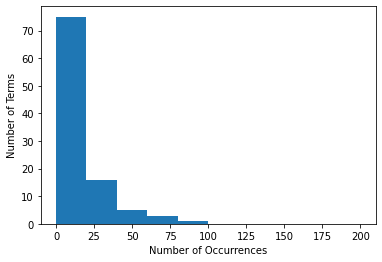

In [183]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [184]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [185]:
corpus_df.head().T

Doc_ID,1,10,11,12,13
DSI_Title,Doc1,Doc10,Doc11,Doc12,Doc13
Student Name,Team,Team,Team,Team,Team
Text,Hello! how can i help you ?,"In machine learning, the problem of unsupervis...",k-means clustering is a method of vector quant...,Principal component analysis (PCA) is a statis...,Decision tree learning uses a decision tree as...
Descriptor,1,10,11,12,13
Doc_ID,1,10,11,12,13
lemmas,"[hello, help]","[machine, learning, problem, unsupervised, lea...","[k, mean, clustering, method, vector, quantiza...","[principal, component, analysis, pca, statisti...","[decision, tree, learning, use, decision, tree..."
lemmas_joined,hello help,machine learning problem unsupervised learning...,k mean clustering method vector quantization o...,principal component analysis pca statistical p...,decision tree learning use decision tree predi...
raw_sentences,"[Hello!, how can i help you ?]","[In machine learning, the problem of unsupervi...",[k-means clustering is a method of vector quan...,[Principal component analysis (PCA) is a stati...,[Decision tree learning uses a decision tree a...
sentences_lemmatized,"[, ]",[machine learning problem learning structure d...,[k mean method vector signal processing analys...,[analysis set observation variable set value v...,[decision tree learning decision tree model ma...


# KG Extraction

In [186]:
corpus_text_sentences = [y for x in corpus_df.raw_sentences for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'Unsupervised learning is closely related to the problem of density estimation in statistics.'

In [187]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 326/326 [00:04<00:00, 80.92it/s]


In [188]:
entity_pairs

[['', ''],
 ['how  i', 'you'],
 ['unsupervised  that', 'unlabeled  data'],
 ['examples', 'potential  solution'],
 ['This', 'supervised  learning'],
 ['Unsupervised  learning', 'closely density statistics'],
 ['other  that', 'key  data'],
 ['Many  methods', 'unsupervised data mining data'],
 ['Approaches', 'e.g.  means'],
 ['', 'such ExpectationÐmaximization algorithm'],
 ['', 'moments'],
 ['organizing network map', 'unsupervised learning algorithms'],
 ['nearby  locations', 'similar  properties'],
 ['problem user', 'defined  constant'],
 ['ART networks', 'automatic target recognition'],
 ['first  version', 'Carpenter'],
 ['originally signal that', 'data mining'],
 ['clustering', 'aims'],
 ['', ''],
 ['k observation', 'nearest  cluster'],
 ['', ''],
 ['This', 'Voronoi cells'],
 ['heuristic  that', 'local  optimum'],
 ['These', 'iterative refinement algorithms'],
 ['clusters', 'different  shapes'],
 ['algorithm', 'nearest  neighbor'],
 ['statistical  that', 'uncorrelated  variables'],
 [

In [189]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
#relations
#pd.Series(relations).value_counts()[:50]
#kg_df
# kg_df = find_sources_and_targets_with_patterns(['Logistic  regression'], kg_df)
kg_df = find_sources_and_targets_with_patterns(['regression'], kg_df)



In [190]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df = find_sources_and_targets_with_patterns(['Logistic  regression'], kg_df)

In [191]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.source = kg_df['source'].apply(lambda x :clean_doc_KG(x))
#kg_df.source = kg_df.source.remove_stop_words(corpus_text_sentences)
#kg_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [192]:
kg_df.head()

,source,target,edge
198,logistic regression,linear regression,seen as
203,logistic regression,medical sciences,used
210,random field,logistic regression,used in natural
215,logistic regression,independent variables,used
308,logistic regression,linear regression,seen as


In [193]:
len(corpus_text_sentences)

326

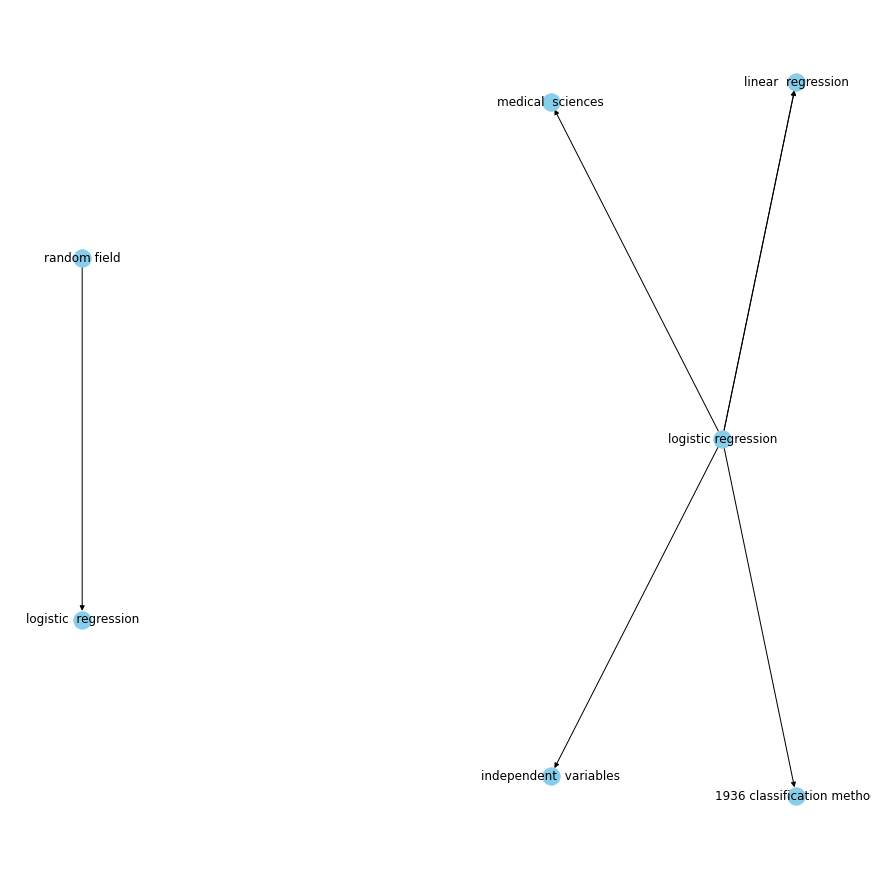

In [194]:
plot_graph(kg_df, use_circular=False)

In [195]:

source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df2 = find_sources_and_targets_with_patterns(['unsupervised'], kg_df)
kg_df2


,source,target,edge
2,unsupervised that,unlabeled data,is
7,Many methods,unsupervised data mining data,based on
11,organizing network map,unsupervised learning algorithms,used unsupervised
159,Deep learning algorithms,unsupervised learning tasks,applied to unsupervised
161,deep that,unsupervised manner,are deep
282,groups,unsupervised task,known


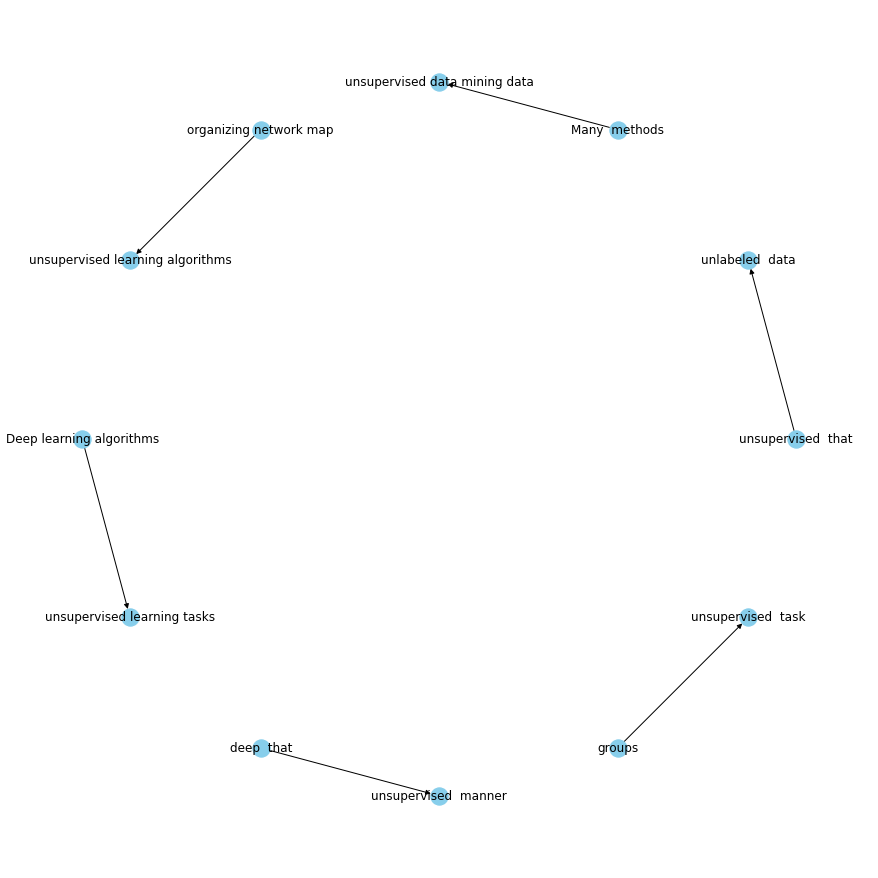

In [196]:
plot_graph(kg_df2, use_circular=True)

In [197]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df3 = find_sources_and_targets_with_patterns(['training'], kg_df)
kg_df3

,source,target,edge
59,training that,individual trees,operate by
60,Random forests,training set,correct for
65,variation,chosen training tree,grown
106,connection which,training,thought of
221,Supervised learning,labeled training,is
222,training data,training examples,consist of
224,inferred training which,new examples,analyzes
226,This,inductive training bias,requires
229,,training examples,Determine
230,kind,training set,decide


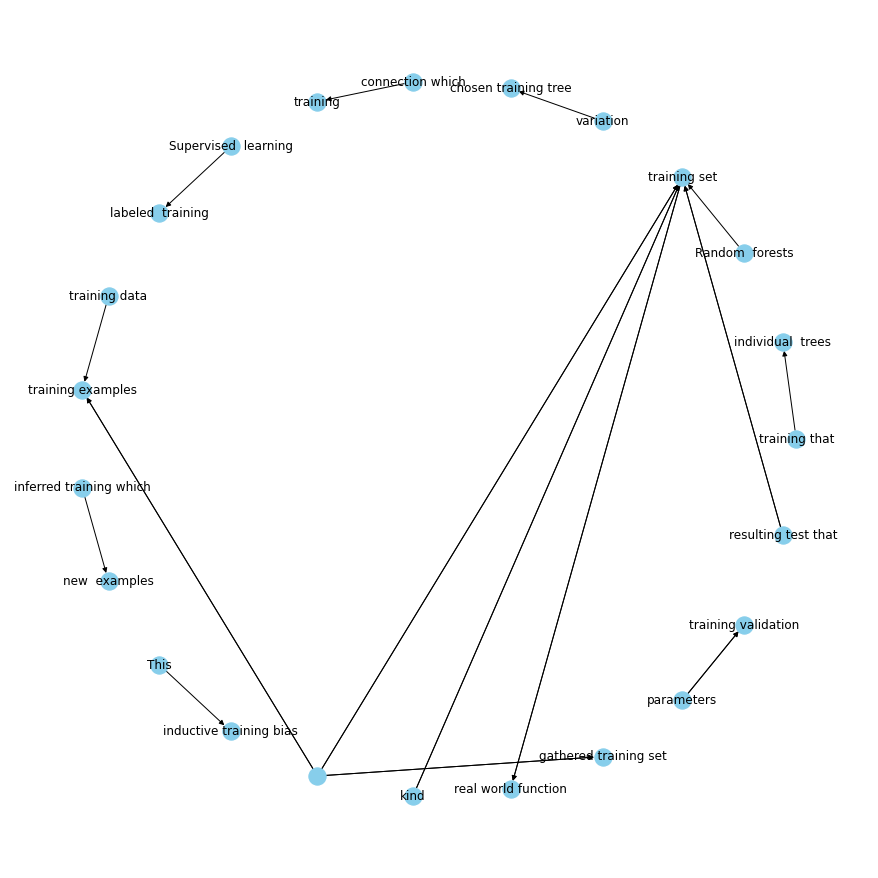

In [198]:
plot_graph(kg_df3, use_circular=True)

In [199]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df4 = find_sources_and_targets_with_patterns(['network'], kg_df)
kg_df4

,source,target,edge
11,organizing network map,unsupervised learning algorithms,used unsupervised
14,ART networks,automatic target recognition,used for many
91,Neural network,,redirects
92,,neural network,see
102,Examinations,neural networks,inspired
103,together processing which,neural network,connected
104,neural network,,is
108,neural network,usually statistics,refers to
123,deep learning,neural networks,characterized as
137,neural networks,biological communication systems,inspired by


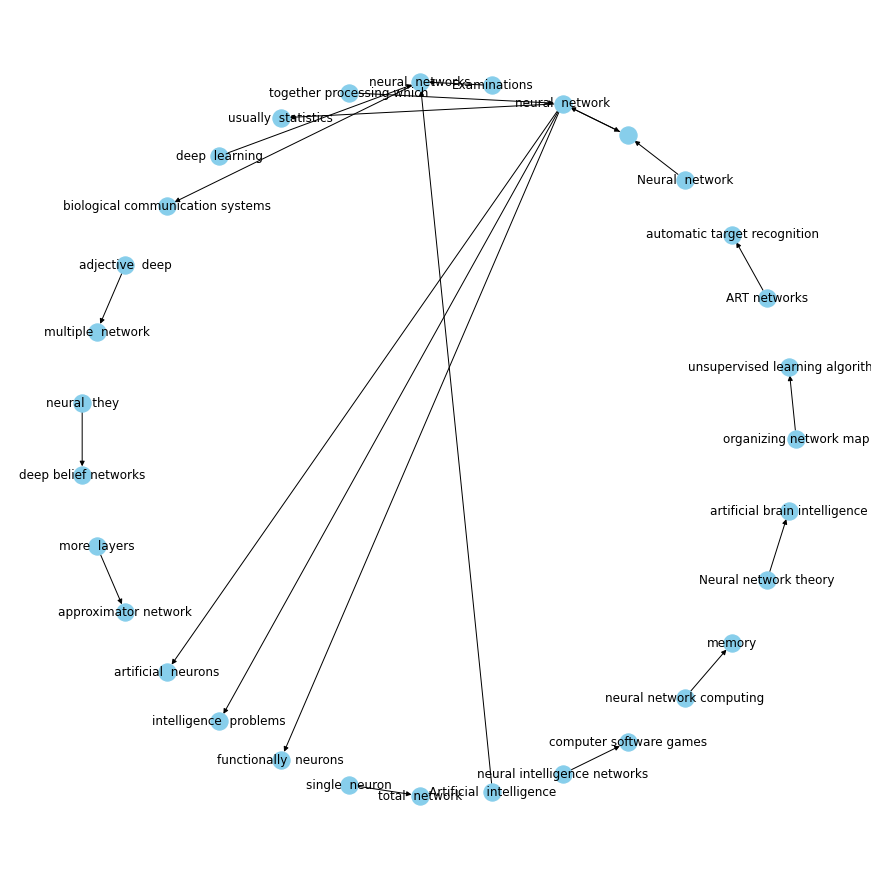

In [200]:
plot_graph(kg_df4, use_circular=True)

In [201]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
kg_df5 = find_sources_and_targets_with_patterns(['loss'], kg_df)
kg_df5

,source,target,edge
186,boosting it,differentiable loss function,built in
211,observed regression outcome,alive loss,Binomial
317,optimization problem,loss function,seeks
324,optimal loss,desired value,is
325,financial risk function,monetary loss,mapped to


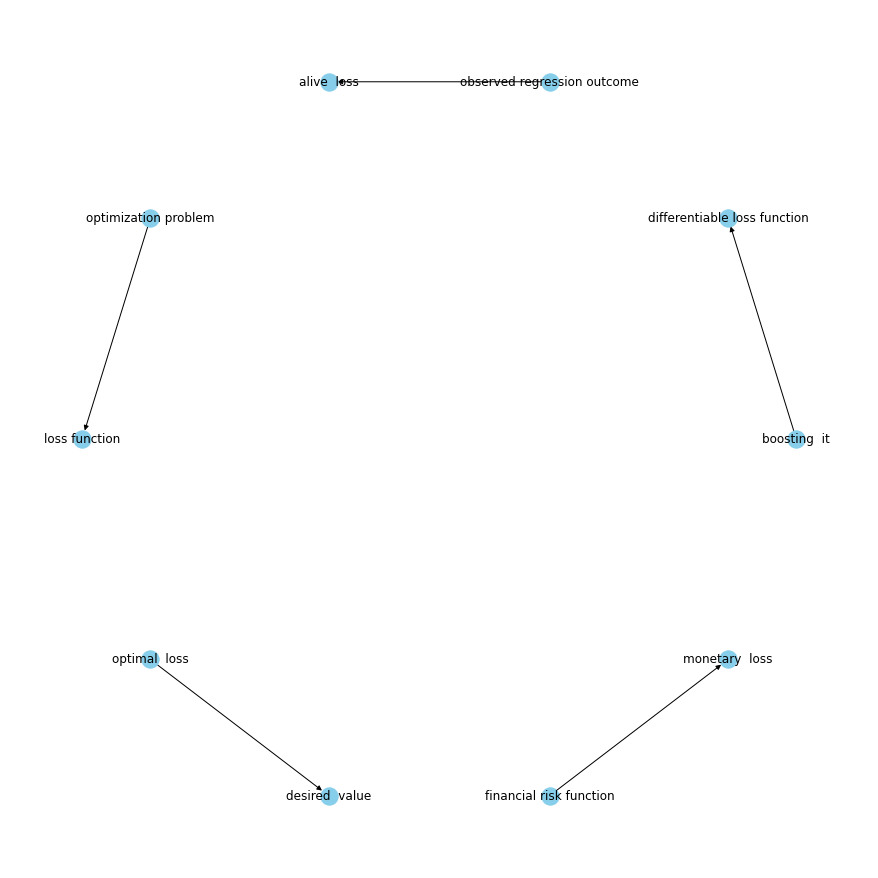

In [202]:
plot_graph(kg_df5, use_circular=True)